In [100]:
import numpy as np
import pandas as pd
import itertools
#from tqdm import tqdm
import matplotlib.pyplot as plt
#from pandas_datareader import data as web
plt.style.use("default")
import re
import requests
from bs4 import BeautifulSoup
# For reproducibility
np.random.seed(42)


In [101]:
# ------------------------------
# Universe from daily screener output (etf_screened_today.csv)
# ------------------------------
from pathlib import Path
repo_root = Path.cwd().parent

config_dir = repo_root / "data"
config_dir.mkdir(parents=True, exist_ok=True)

_screen_path = config_dir / "etf_screened_today.csv"

screen_df = pd.read_csv(_screen_path)

if "include_for_algo" not in screen_df.columns:
    raise ValueError(f"Screener CSV missing include_for_algo column: {_screen_path}")

screen_pass = screen_df[screen_df["include_for_algo"] == True].copy()

# Normalize tickers
for col in ["ETF", "Underlying"]:
    if col in screen_pass.columns:
        screen_pass[col] = (
            screen_pass[col].astype(str).str.strip().str.replace(".", "-", regex=False).str.upper()
        )

if "LevType" not in screen_pass.columns:
    raise ValueError(f"Screener CSV missing LevType column: {_screen_path}")
if "Underlying" not in screen_pass.columns or "ETF" not in screen_pass.columns:
    raise ValueError(f"Screener CSV must contain ETF + Underlying columns: {_screen_path}")

lt = screen_pass["LevType"].astype(str).str.upper()

cc_mask = lt.str.contains("CC") | lt.str.contains("COVER") | lt.str.contains("YM") | lt.str.contains("YIELD")
lev2_mask = (lt.str.contains("2") | lt.str.contains("2X") | lt.str.contains("LEV2") | lt.str.contains("DX")) & ~lt.str.contains("3")

# Build pair-definition dataframes expected by the rest of the notebook
ym_df = screen_pass.loc[cc_mask, ["ETF", "Underlying"]].copy()
ym_df["LevType"] = "CC"

dx_df = screen_pass.loc[lev2_mask, ["ETF", "Underlying"]].copy()
dx_df["LevType"] = "2x"

# Keep cc_df for backward compatibility with existing concat logic (can be empty)
cc_df = pd.DataFrame(columns=["ETF", "Underlying", "LevType"])

# Convenience lists (if later cells expect them)
covered_call_pairs_expanded = list(zip(ym_df["ETF"], ym_df["Underlying"]))
leverage_pairs = list(zip(dx_df["ETF"], dx_df["Underlying"]))

print(f"Screener path: {_screen_path}")
print(f"Included pairs: CC={len(ym_df)}, 2x={len(dx_df)}")
print("Sample CC pairs:", covered_call_pairs_expanded)
print("Sample 2x pairs:", leverage_pairs)


Screener path: c:\Users\werdn\Documents\Investing\ls-algo\data\etf_screened_today.csv
Included pairs: CC=33, 2x=56
Sample CC pairs: [('QYLD', 'QQQ'), ('QYLG', 'QQQ'), ('QQQX', 'QQQ'), ('JEPQ', 'QQQ'), ('XYLD', 'SPY'), ('XYLG', 'SPY'), ('JEPI', 'SPY'), ('SPYI', 'SPY'), ('ABNY', 'ABNB'), ('AMDY', 'AMD'), ('AMZY', 'AMZN'), ('BABO', 'BABA'), ('BRKC', 'BRK-B'), ('FBY', 'META'), ('GOOY', 'GOOGL'), ('HOOY', 'HOOD'), ('MARO', 'MARA'), ('NFLY', 'NFLX'), ('NVDY', 'NVDA'), ('PYPY', 'PYPL'), ('RBLY', 'RBLX'), ('SNOY', 'SNOW'), ('TSLY', 'TSLA'), ('TSMY', 'TSM'), ('XYZY', 'XYZ'), ('AMZW', 'AMZN'), ('ARMW', 'ARM'), ('COIW', 'COIN'), ('HOOW', 'HOOD'), ('MSFW', 'MSFT'), ('MSTW', 'MSTR'), ('NFLW', 'NFLX'), ('PLTW', 'PLTR')]
Sample 2x pairs: [('AAPU', 'AAPL'), ('AMUU', 'AMD'), ('AMZU', 'AMZN'), ('AVL', 'AVGO'), ('BOEU', 'BA'), ('BRKU', 'BRK-B'), ('CSCL', 'CSCO'), ('ETHU', 'ETHA'), ('GGLL', 'GOOGL'), ('MUU', 'MU'), ('NFXL', 'NFLX'), ('PALU', 'PANW'), ('QCMU', 'QCOM'), ('XOMX', 'XOM'), ('XXRP', 'GXRP'), ('

In [102]:
all_df = pd.concat([dx_df, cc_df, ym_df], ignore_index=True)
# make sure to exclude jp morgan
all_df = all_df.dropna(subset=["Underlying"])
all_df = all_df[all_df["Underlying"].astype(str).str.strip() != ""]

# Drop duplicate ETFs or duplicate rows if needed
all_df = all_df.drop_duplicates(subset=["ETF"]).reset_index(drop=True)
# Replace dots with dashes for Yahoo Finance compatibility
all_df["ETF"] = all_df["ETF"].str.replace(".", "-", regex=False)
all_df["Underlying"] = all_df["Underlying"].str.replace(".", "-", regex=False)

# Now create clean ticker lists
all_tickers = all_df["ETF"].tolist()

In [103]:
import ftplib

ftp = ftplib.FTP("ftp2.interactivebrokers.com")
ftp.login(user="shortstock", passwd="")  # password is blank / anonymous

files = ftp.nlst()
print(files)

ftp.quit()


['australia.txt', 'australia.txt.md5', 'austria.txt', 'austria.txt.md5', 'belgium.txt', 'belgium.txt.md5', 'british.txt', 'british.txt.md5', 'canada.txt', 'canada.txt.md5', 'dutch.txt', 'dutch.txt.md5', 'france.txt', 'france.txt.md5', 'germany.txt', 'germany.txt.md5', 'hongkong.txt', 'hongkong.txt.md5', 'india.txt', 'india.txt.md5', 'italy.txt', 'italy.txt.md5', 'japan.txt', 'japan.txt.md5', 'mexico.txt', 'mexico.txt.md5', 'singapore.txt', 'singapore.txt.md5', 'spain.txt', 'spain.txt.md5', 'stockmargin_final_dtls.IB-AU.dat', 'stockmargin_final_dtls.IB-AU.dat.md5', 'stockmargin_final_dtls.IB-CAN.dat', 'stockmargin_final_dtls.IB-CAN.dat.md5', 'stockmargin_final_dtls.IB-HK.dat', 'stockmargin_final_dtls.IB-HK.dat.md5', 'stockmargin_final_dtls.IB-IN.dat', 'stockmargin_final_dtls.IB-IN.dat.md5', 'stockmargin_final_dtls.IB-JP.dat', 'stockmargin_final_dtls.IB-JP.dat.md5', 'stockmargin_final_dtls.IB-SG.dat', 'stockmargin_final_dtls.IB-SG.dat.md5', 'stockmargin_final_dtls.IB-UKL.dat', 'stockmarg

'221 Goodbye.'

In [104]:
import ftplib
import io

def fetch_ibkr_shortstock_file(filename="usa.txt") -> pd.DataFrame:
    ftp = ftplib.FTP("ftp2.interactivebrokers.com")
    ftp.login(user="shortstock", passwd="")

    buf = io.BytesIO()
    ftp.retrbinary(f"RETR {filename}", buf.write)
    ftp.quit()

    buf.seek(0)
    text = buf.getvalue().decode("utf-8", errors="ignore")
    lines = [ln for ln in text.splitlines() if ln.strip()]

    # Find the header line that starts with #SYM|
    header_idx = None
    for i, ln in enumerate(lines):
        if ln.startswith("#SYM|"):
            header_idx = i
            break
    if header_idx is None:
        raise ValueError("Could not find header line starting with '#SYM|'")

    header_line = lines[header_idx]
    data_lines = lines[header_idx + 1:]

    # Build column names from header
    header_cols = [c.strip().lstrip("#").lower() for c in header_line.split("|")]

    # Join data lines back to a CSV-like string
    data_str = "\n".join(data_lines)
    data_buf = io.StringIO(data_str)

    # Read data; allow Python engine for safety
    df = pd.read_csv(
        data_buf,
        sep="|",
        header=None,
        engine="python"
    )

    # Trim / align columns
    n_cols = min(len(header_cols), df.shape[1])
    df = df.iloc[:, :n_cols]
    df.columns = header_cols[:n_cols]

    # Drop any empty / unnamed trailing columns
    df = df.drop(columns=[c for c in df.columns if not c or str(c).startswith("unnamed")], errors="ignore")

    return df


In [105]:
short_df = fetch_ibkr_shortstock_file("usa.txt")
short_df.head()


,sym,cur,name,con,isin,rebaterate,feerate,available,figi
0,A,USD,AGILENT TECHNOLOGIES INC,1715006.0,XXXXXXXU1016,3.3518,0.2782,5200000,BBG000C2V3D6
1,AA,USD,ALCOA CORP,251962528.0,XXXXXXX21065,3.3518,0.2782,5500000,BBG00B3T3HD3
2,AAA,USD,ALTERNATIVE ACCESS FIRST PRI,591368776.0,XXXXXXXX6105,-2.6020,6.2320,5000,BBG01B0JRCS6
3,AAAA,USD,AMPLIUS AGGRESSIVE A ALL ETF,799151665.0,XXXXXXXQ6897,-69.4572,73.0872,95000,BBG01W275XX6
4,AAAC,USD,COLUMBIA AAA CLO ETF,837910779.0,XXXXXXXL7635,NaN,NaN,35000,BBG01YZNRVY0


In [106]:
short_df.columns

Index(['sym', 'cur', 'name', 'con', 'isin', 'rebaterate', 'feerate',
       'available', 'figi'],
      dtype='object')

In [107]:
import numpy as np

def build_ibkr_short_maps(
    tickers,
    filename="usa.txt",
    default_borrow=0.05,   # 5% if not found
    default_rebate=0.0
):
    """
    Use IBKR's public shortstock FTP file to build:
      - net borrow rate map (fee - rebate)
      - rebate rate map
      - available-shares map

    All rates returned as decimals (e.g. 0.12 = 12% per year).
    """
    tickers = [t.upper() for t in tickers]

    short_df = fetch_ibkr_shortstock_file(filename)

    # Clean / normalize columns
    short_df["sym"] = short_df["sym"].astype(str).str.upper().str.strip()

    # Some files are in percent (e.g. 3.6300 means 3.63%)
    # Convert to decimals
    short_df["rebate_annual"] = pd.to_numeric(short_df["rebaterate"], errors="coerce") / 100.0
    short_df["fee_annual"]    = pd.to_numeric(short_df["feerate"],    errors="coerce") / 100.0
    short_df["available_int"] = pd.to_numeric(short_df["available"],  errors="coerce")

    # Net borrow cost to you ≈ fee - rebate.
    # If this goes negative (i.e. you actually earn carry),
    # you can either keep it or clip at 0. I'll clip at 0 to be conservative.
    short_df["net_borrow_annual"] = short_df["fee_annual"] - short_df["rebate_annual"]
    short_df["net_borrow_annual"] = short_df["net_borrow_annual"].clip(lower=0)

    # Filter only the symbols we care about
    mask = short_df["sym"].isin(tickers)
    sub = short_df.loc[mask].copy()

    borrow_map = {}
    rebate_map = {}
    available_map = {}

    for _, row in sub.iterrows():
        sym = row["sym"]
        if pd.notna(row["net_borrow_annual"]):
            borrow_map[sym] = float(row["net_borrow_annual"])
        if pd.notna(row["rebate_annual"]):
            rebate_map[sym] = float(row["rebate_annual"])
        if pd.notna(row["available_int"]):
            available_map[sym] = int(row["available_int"])

    # Defaults for anything missing
    borrow_map["default"] = default_borrow
    rebate_map["default"] = default_rebate

    return borrow_map, rebate_map, available_map


In [108]:
borrow_map, rebate_map, available_map = build_ibkr_short_maps(
    tickers=all_tickers,
    filename="usa.txt",
    default_borrow=0.05,
    default_rebate=0.0
)

borrow_map


{'AAPB': 0.054494,
 'AAPU': 0.07045000000000001,
 'ABNY': 0.036126000000000005,
 'AMDG': 0.066422,
 'AMDL': 0.027316000000000003,
 'AMDY': 0.036236,
 'AMZU': 0.063716,
 'AMZW': 0.037592,
 'AMZY': 0.042154,
 'AMZZ': 0.00868,
 'APPX': 0.067146,
 'ARMW': 0.072366,
 'AVL': 0.088786,
 'BABO': 0.044410000000000005,
 'BABX': 0.0,
 'BITU': 0.005407999999999998,
 'BOEG': 0.052108,
 'BOEU': 0.052192,
 'BRKC': 0.022378000000000002,
 'BRKU': 0.066122,
 'BTCL': 0.048375999999999995,
 'CEGX': 0.058733999999999995,
 'CELT': 0.028330000000000004,
 'COIW': 0.05855,
 'COTG': 0.071802,
 'CRMG': 0.022712000000000003,
 'CSCL': 0.056103999999999994,
 'CWVX': 0.040644,
 'ETHU': 0.0,
 'ETU': 0.029380000000000003,
 'FBL': 0.0,
 'FBY': 0.0006499999999999978,
 'GGLL': 0.061114,
 'GOOY': 0.04801,
 'GSX': 0.044048000000000004,
 'HOOW': 0.0,
 'HOOY': 0.029254000000000002,
 'INTW': 0.020878000000000004,
 'IREG': 0.099938,
 'JEPI': 0.0,
 'JEPQ': 0.0,
 'LABX': 0.04013,
 'MARO': 0.02339,
 'MDBX': 0.08834,
 'MSFL': 0.04

In [109]:
available_map

{'AAPB': 55000,
 'AAPU': 75000,
 'ABNY': 10000,
 'AMDG': 1000,
 'AMDL': 1200000,
 'AMDY': 55000,
 'AMZU': 40000,
 'AMZW': 35000,
 'AMZY': 150000,
 'AMZZ': 10000,
 'APPX': 150000,
 'ARMW': 3000,
 'AVL': 25000,
 'BABO': 35000,
 'BABX': 650000,
 'BITU': 90000,
 'BOEG': 30000,
 'BOEU': 50000,
 'BRKC': 1000,
 'BRKU': 65000,
 'BTCL': 1000,
 'CEGX': 30000,
 'CELT': 10000,
 'COIW': 150000,
 'COTG': 10000,
 'CRMG': 150000,
 'CSCL': 9000,
 'CWVX': 100000,
 'ETHU': 500000,
 'ETU': 10000,
 'FBL': 40000,
 'FBY': 100000,
 'GGLL': 900000,
 'GOOY': 150000,
 'GSX': 1000,
 'HOOW': 150000,
 'HOOY': 100000,
 'INTW': 100000,
 'IREG': 2000,
 'JEPI': 1200000,
 'JEPQ': 1300000,
 'LABX': 300000,
 'MARO': 55000,
 'MDBX': 500,
 'MSFL': 350000,
 'MSFW': 10000,
 'MSFX': 40000,
 'MSTW': 200000,
 'MUU': 400000,
 'NFLU': 80000,
 'NFLW': 50000,
 'NFLY': 100000,
 'NFXL': 80000,
 'NUG': 400,
 'NVDB': 7000,
 'NVDG': 40000,
 'NVDL': 40000,
 'NVDY': 2000000,
 'PALU': 25000,
 'PANG': 4000,
 'PLTA': 3000,
 'PLTW': 200000,
 '

In [110]:
combos = [
    ("Never", "W"),
    ("W","W"),
    ("M","W"),
    ("Q","W"),
    ("Never", "M"),
    ("M","M"),
    ("Q","M"),
    ("Q","Q"),
    ("Never", "Q"),
    ("W", "Never"),
    ("M", "Never"),
    ("Q", "Never"),
    ("Never", "Never")
]

In [111]:
def get_rebalance_days(idx: pd.DatetimeIndex, freq: str) -> set[pd.Timestamp]:
    """
    Return a set of pd.Timestamp rebalance days, guaranteed to be:
      - tz-naive
      - elements that appear in idx
      - comparable with loop variable t (which will be from idx)
    """
    if idx.tz is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)

    idx = pd.DatetimeIndex(idx)  # ensure DatetimeIndex
    if len(idx) == 0:
        return set()

    freq = str(freq).upper()

    # Always include the first day so portfolio can initialize when eligible
    days = {pd.Timestamp(idx[0])}

    if freq in ("NEVER",):
        return days

    if freq in ("D", "DAILY"):
        return set(pd.Timestamp(x) for x in idx)

    if freq not in ("W", "M", "Q"):
        raise ValueError("freq must be one of: 'D','W','M','Q','Never'")

    # last trading day in each period
    periods = idx.to_period(freq)
    last_days = (
        pd.Series(idx, index=idx)
        .groupby(periods)
        .apply(lambda s: s.iloc[-1])
        .tolist()
    )

    for d in last_days:
        days.add(pd.Timestamp(d))

    return days


In [112]:
def first_valid_date(rets: pd.DataFrame, sym: str) -> pd.Timestamp | None:
    # prefer _TR if present
    candidates = [f"{sym}_TR", sym]
    for col in candidates:
        if col in rets.columns:
            s = rets[col]
            # valid = non-NA (you can also add: & (s != 0) if you want)
            fv = s.first_valid_index()
            if fv is not None:
                return pd.Timestamp(fv)
    return None

def build_pair_start_dates(rets: pd.DataFrame, pairs: list[tuple[str, str]]):
    """
    pairs are (underlying, etf) in your convention.
    returns dict: {(und, etf): start_date}
    """
    pair_start = {}
    for und, etf in pairs:
        und0 = und.replace(".", "-")
        etf0 = etf.replace(".", "-")

        d1 = first_valid_date(rets, und0)
        d2 = first_valid_date(rets, etf0)

        if d1 is None or d2 is None:
            continue  # cannot trade this pair at all

        pair_start[(und0, etf0)] = max(d1, d2)
    return pair_start

def apply_pair_start_mask(pair_rets_df: pd.DataFrame, pair_start_dates: dict, pairs: list[tuple[str,str]]):
    """
    pair_rets_df columns are pair keys like "UND|ETF"
    sets returns to 0 before that pair's start date (i.e., excludes it)
    """
    out = pair_rets_df.copy()
    for und, etf in pairs:
        key = f"{und.upper().replace('.','-')}|{etf.upper().replace('.','-')}"
        if key not in out.columns:
            continue
        start = pair_start_dates.get((und.replace(".","-"), etf.replace(".","-")))
        if start is None:
            # if we somehow created it but don't have a start date, zero it out completely
            out[key] = 0.0
            continue
        out.loc[out.index < start, key] = 0.0
    return out



def build_symbol_start_from_pairs(rets: pd.DataFrame, pairs: list[tuple[str, str]]) -> dict[str, pd.Timestamp]:
    """Return dict mapping each symbol in each pair to the pair's start date (max of leg start dates).
    Symbols are normalized by replacing '.'->'-'. Uses *_TR columns if present.
    """
    pair_start = build_pair_start_dates(rets, pairs)
    sym_start: dict[str, pd.Timestamp] = {}
    for (und, etf), d0 in pair_start.items():
        und_n = und.replace(".", "-")
        etf_n = etf.replace(".", "-")
        sym_start[und_n] = d0
        sym_start[etf_n] = d0
    return sym_start

def build_pairs_from_df(df: pd.DataFrame, und_col: str="Underlying", etf_col: str="ETF") -> list[tuple[str,str]]:
    """Build (underlying, etf) pairs from a dataframe with Underlying/ETF columns."""
    return list(zip(
        df[und_col].astype(str).str.replace(".", "-", regex=False),
        df[etf_col].astype(str).str.replace(".", "-", regex=False),
    ))


In [113]:
import yfinance as yf

def get_total_return_series(ticker, start=None, end=None):
    """
    Long-only total return price series:
    TR_t = TR_{t-1} * (Close_t + Div_t) / Close_{t-1}
    """
    t = yf.Ticker(ticker)

    df = t.history(period='max', auto_adjust=False, actions=True)

    if df.empty or "Close" not in df.columns:
        print(f"[WARN] No Yahoo data for {ticker}")
        return pd.Series(dtype=float)

    # Restrict dates if provided
    if start is not None:
        df = df[df.index >= pd.to_datetime(start)]
    if end is not None:
        df = df[df.index <= pd.to_datetime(end)]

    if df.empty:
        print(f"[WARN] No data in range for {ticker}")
        return pd.Series(dtype=float)

    close = df["Close"]
    divs = df.get("Dividends", pd.Series(0.0, index=df.index))

    divs = divs.reindex(close.index, fill_value=0.0)

    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0

    tr_price = close.iloc[0] * rel.cumprod()
    tr_price.name = ticker + "_TR"
    return tr_price


In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# CONFIG
# ------------------------------
trading_days   = 252
default_borrow = 0.05   # 5% annual if not in map

# Hedge ratios:
CC_SHORT_RATIO   = -1.0   # long 1 underlying : short 1 CC ETF (YieldMax 1x)
LEV2_SHORT_RATIO = -0.5   # long 1 underlying : short 0.5 of a 2x ETF

# ------------------------------
# 0. TAG SOURCES & BUILD ALL_DF
# ------------------------------
dx_df = dx_df.copy()
ym_df = ym_df.copy()

dx_df["LevType"] = "2x"
ym_df["LevType"] = "CC"

# Combine dx (2x) and ym (covered call) – EXCLUDING cc_df entirely
all_df = pd.concat([dx_df, ym_df], ignore_index=True)

print("Universe of ETFs (raw):")
print(all_df[["Underlying", "ETF", "LevType"]])

# Clean underlying / ETF tickers
all_df = all_df.dropna(subset=["Underlying"])
all_df = all_df[all_df["Underlying"].astype(str).str.strip() != ""].copy()
all_df = all_df.drop_duplicates(subset=["ETF"]).reset_index(drop=True)

all_df["ETF"]        = all_df["ETF"].str.replace(".", "-", regex=False)
all_df["Underlying"] = all_df["Underlying"].str.replace(".", "-", regex=False)

print("\nUniverse after cleaning:")
print(all_df[["Underlying", "ETF", "LevType"]])

# ------------------------------
# 1. MERGE IN HISTORICAL CAGRs (results_df_mc)
# ------------------------------
hist_cols_needed = ["Underlying", "ETF", "cagr_port_hist"]
# ------------------------------
# 1. MERGE IN HISTORICAL CAGRs (FROM etf_screened_today.csv)
# ------------------------------
from pathlib import Path
repo_root = Path.cwd().parent

config_dir = repo_root / "data"
config_dir.mkdir(parents=True, exist_ok=True)

_screen_path = config_dir / "etf_screened_today.csv"

screen_df = pd.read_csv(_screen_path)

# Normalize tickers like the rest of the notebook
for c in ["ETF", "Underlying"]:
    if c in screen_df.columns:
        screen_df[c] = (
            screen_df[c].astype(str)
            .str.strip()
            .str.replace(".", "-", regex=False)
            .str.upper()
        )

# Keep only what you need for the merge
hist_cols_needed = ["Underlying", "ETF", "cagr_port_hist"]
missing = [c for c in hist_cols_needed if c not in screen_df.columns]
if missing:
    raise ValueError(f"etf_screened_today.csv missing columns: {missing}")

# OPTIONAL:
# If you only want to test things that passed today's screen, uncomment:
# screen_df = screen_df[screen_df["include_for_algo"] == True].copy()

hist_df = screen_df[hist_cols_needed].drop_duplicates(["Underlying", "ETF"])

all_full = all_df.merge(
    hist_df,
    on=["Underlying", "ETF"],
    how="left",
    validate="1:1"
)

# Drop rows with no historical CAGR (same behavior as before)
all_full = all_full.dropna(subset=["cagr_port_hist"]).copy()

# ------------------------------
# 2. ATTACH CURRENT BORROW RATES
# ------------------------------
def get_borrow_current(etf):
    if "borrow_map" in globals() and borrow_map is not None:
        if etf in borrow_map:
            return borrow_map[etf]
        if "default" in borrow_map:
            return borrow_map["default"]
    return default_borrow

all_full["borrow_current"] = all_full["ETF"].apply(get_borrow_current)

# ------------------------------
# 3. FILTER: EXCLUDE (CAGR<0 AND borrow>10%)
# ------------------------------
bad_mask = (all_full["cagr_port_hist"] < 0) & (all_full["borrow_current"] > 0.10)
bad_etfs = set(all_full.loc[bad_mask, "ETF"])

print("\nExcluding ETFs (neg hist CAGR AND borrow >10%):")
print(bad_etfs)

all_good = all_full[~all_full["ETF"].isin(bad_etfs)].copy()
if all_good.empty:
    raise ValueError("No ETFs left after filtering CAGR/borrow condition.")

print("\nETFs used in portfolio after filter:")
print(all_good[["Underlying", "ETF", "LevType", "cagr_port_hist", "borrow_current"]])

# ------------------------------
# 4. BUILD PER-PAIR WEIGHTS (1 long underlying per ETF)
# ------------------------------
def short_ratio_for_row(row):
    if row["LevType"] == "2x":
        return LEV2_SHORT_RATIO
    else:  # YieldMax / CC
        return CC_SHORT_RATIO

all_good["w_etf_per_pair"]   = all_good.apply(short_ratio_for_row, axis=1)
all_good["w_under_per_pair"] = 1.0  # one long underlying per ETF

# Aggregate: e.g. MSTR with MSTY & MSTX → +2 MSTR, -1 MSTY, -0.5 MSTX
w_under_by_und = all_good.groupby("Underlying")["w_under_per_pair"].sum()
w_etf_by_etf   = all_good.groupby("ETF")["w_etf_per_pair"].sum()

print("\nNet underlying weights:")
print(w_under_by_und)

print("\nNet ETF weights:")
print(w_etf_by_etf)

# Borrow daily map per ETF
borrow_daily_map = (
    all_good
    .drop_duplicates(subset=["ETF"])
    .set_index("ETF")["borrow_current"] / trading_days
)

# ------------------------------
# 5. LOAD TOTAL RETURN SERIES FOR ALL SYMBOLS
# ------------------------------
all_symbols = sorted(set(w_under_by_und.index) | set(w_etf_by_etf.index))

price_dict = {}
for sym in all_symbols:
    tr = get_total_return_series(sym)
    if tr.empty:
        print(f"WARNING: no TR data for {sym}, zeroing its weight.")
        if sym in w_under_by_und.index:
            w_under_by_und.loc[sym] = 0.0
        if sym in w_etf_by_etf.index:
            w_etf_by_etf.loc[sym] = 0.0
        continue
    price_dict[f"{sym}_TR"] = tr

prices = pd.DataFrame(price_dict)
rets   = prices.pct_change()

# Drop zero-weight symbols
w_under_by_und = w_under_by_und[w_under_by_und != 0]
w_etf_by_etf   = w_etf_by_etf[w_etf_by_etf != 0]

# ------------------------------
# 5b. SET GLOBAL BACKTEST START DATE
# ------------------------------
# Start backtest when the FIRST ETF (dx_df or ym_df) starts having data.
etf_tr_cols = [f"{etf}_TR" for etf in w_etf_by_etf.index if f"{etf}_TR" in rets.columns]

start_dates = []
for col in etf_tr_cols:
    first_idx = rets[col].first_valid_index()
    if first_idx is not None:
        start_dates.append(first_idx)

if not start_dates:
    raise ValueError("No valid ETF return series to determine backtest start.")

backtest_start = min(start_dates)

print("\nGlobal backtest start date (first ETF data):", backtest_start)

# Restrict rets (and thus portfolio) to dates >= backtest_start
BACKTEST_START_DATE = "2022-01-01"   # <-- change this

start_dt = pd.Timestamp(BACKTEST_START_DATE)

idx = rets.index
if getattr(idx, "tz", None) is not None:
    # match the index tz (e.g., America/New_York)
    start_dt = start_dt.tz_localize(idx.tz)

rets = rets.loc[rets.index >= start_dt].copy()

print("Backtest start:", rets.index.min())
print("Backtest end:", rets.index.max())


# ------------------------------
# 6. COMPONENT DATE RANGES / METADATA
# ------------------------------
component_info = []
all_good_unique = all_good.drop_duplicates(subset=["ETF"])

for _, row in all_good_unique.iterrows():
    und = row["Underlying"]
    etf = row["ETF"]
    lev = row["LevType"]
    borrow_annual = row["borrow_current"]

    und_col = f"{und}_TR"
    etf_col = f"{etf}_TR"

    if und_col not in rets.columns or etf_col not in rets.columns:
        continue

    pair_df = rets[[und_col, etf_col]].dropna()
    if pair_df.empty:
        continue

    start_date = pair_df.index.min()
    end_date   = pair_df.index.max()
    n_days     = len(pair_df)

    w_u = w_under_by_und.get(und, 0.0)
    w_e = w_etf_by_etf.get(etf, 0.0)

    component_info.append({
        "Underlying": und,
        "ETF": etf,
        "LevType": lev,
        "w_under_total": w_u,
        "w_etf_total": w_e,
        "BorrowAnnual": borrow_annual,
        "StartDate": start_date,
        "EndDate": end_date,
        "NumTradingDays": n_days,
    })

components_df = pd.DataFrame(component_info)
components_df = components_df.sort_values(["StartDate", "ETF"])

print("\nComponents used in the global portfolio and their date ranges:\n")
if not components_df.empty:
    print(components_df.to_string(index=False))
else:
    print("No overlapping data for any Underlying/ETF pair.")

# ------------------------------
# 7. BUILD DAILY PORTFOLIO RETURNS (RAW, NOT NORMALIZED)
# ------------------------------
port_ret = pd.Series(0.0, index=rets.index)

# Underlying leg
for und, w_u in w_under_by_und.items():
    col = f"{und}_TR"
    if col not in rets.columns:
        print(f"Missing return series for underlying {und}, skipping.")
        continue
    port_ret = port_ret.add(w_u * rets[col], fill_value=0.0)

# ETF legs (short) + borrow cost
for etf, w_e in w_etf_by_etf.items():
    col = f"{etf}_TR"
    if col not in rets.columns:
        print(f"Missing return series for ETF {etf}, skipping.")
        continue

    port_ret = port_ret.add(w_e * rets[col], fill_value=0.0)

    b_daily = borrow_daily_map.get(etf, default_borrow / trading_days)
    port_ret = port_ret.add(-abs(w_e) * b_daily, fill_value=0.0)

port_ret = port_ret.dropna()
port_ret.name = "Global_LongUnderlyings_ShortYM_2x_withBorrow_RAW"

Universe of ETFs (raw):
   Underlying   ETF LevType
0        AAPL  AAPU      2x
1         AMD  AMUU      2x
2        AMZN  AMZU      2x
3        AVGO   AVL      2x
4          BA  BOEU      2x
..        ...   ...     ...
84       HOOD  HOOW      CC
85       MSFT  MSFW      CC
86       MSTR  MSTW      CC
87       NFLX  NFLW      CC
88       PLTR  PLTW      CC

[89 rows x 3 columns]

Universe after cleaning:
   Underlying   ETF LevType
0        AAPL  AAPU      2x
1         AMD  AMUU      2x
2        AMZN  AMZU      2x
3        AVGO   AVL      2x
4          BA  BOEU      2x
..        ...   ...     ...
84       HOOD  HOOW      CC
85       MSFT  MSFW      CC
86       MSTR  MSTW      CC
87       NFLX  NFLW      CC
88       PLTR  PLTW      CC

[89 rows x 3 columns]

Excluding ETFs (neg hist CAGR AND borrow >10%):
set()

ETFs used in portfolio after filter:
   Underlying   ETF LevType  cagr_port_hist  borrow_current
0        AAPL  AAPU      2x        0.010941        0.070450
1         AMD  AMUU

In [115]:
def perf_stats(ret, label):
    T = len(ret)
    if T == 0:
        return {"Portfolio": label, "TradingDays": 0,
                "CAGR": np.nan, "Vol": np.nan, "MaxDD": np.nan}
    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1
    vol  = ret.std() * np.sqrt(trading_days)
    curve = (1 + ret).cumprod()
    dd = (curve / curve.cummax() - 1).min()
    return {"Portfolio": label, "TradingDays": T,
            "CAGR": cagr, "Vol": vol, "MaxDD": dd}


In [116]:
def simulate_sleeve_realistic_add_on_rebalance_with_drift(
    rets: pd.DataFrame,
    pairs: list[tuple[str, str]],
    short_ratio: float,
    borrow_daily_map: dict | pd.Series,
    freq: str = "M",
    default_borrow_daily: float = 0.05/252,
    start_when_first_pair_active: bool = True,
    target_gross: float | None = None,
    cap_drift: bool = True,
    gross_cap_mult: float | None = None,
):
    # targets
    if target_gross is None:
        target_gross = float(globals().get("TARGET_GROSS", 1.0))
    if gross_cap_mult is None:
        gross_cap_mult = float(globals().get("GROSS_CAP_MULT", 1.25))

    # tz hygiene FIRST
    rets_local = rets.copy()
    if rets_local.index.tz is not None:
        rets_local.index = rets_local.index.tz_convert("UTC").tz_localize(None)

    idx = rets_local.index
    rebal_days = get_rebalance_days(idx, freq)  # <-- robust rebalance set

    # tradable start per pair (both legs exist)
    pair_start = build_pair_start_dates(rets_local, pairs)

    active_pairs: list[tuple[str, str]] = []
    w_under = pd.Series(dtype=float)
    w_etf   = pd.Series(dtype=float)

    port_ret       = pd.Series(index=idx, dtype=float)
    pair_count     = pd.Series(index=idx, dtype=int)
    gross_exposure = pd.Series(index=idx, dtype=float)

    def scale_to_target_gross(wu: pd.Series, we: pd.Series) -> tuple[pd.Series, pd.Series]:
        gross = wu.abs().sum() + we.abs().sum()
        if not np.isfinite(gross) or gross <= 0:
            return pd.Series(dtype=float), pd.Series(dtype=float)
        scale = target_gross / gross
        return wu * scale, we * scale

    def rebuild_target_weights(active_pairs_local: list[tuple[str,str]]):
        """Equal-weight pairs -> normalize -> scale to target_gross."""
        n = len(active_pairs_local)
        if n == 0:
            return pd.Series(dtype=float), pd.Series(dtype=float)

        pair_weight = 1.0 / n

        wu, we = {}, {}
        for und, etf in active_pairs_local:
            und = und.replace(".", "-")
            etf = etf.replace(".", "-")
            wu[und] = wu.get(und, 0.0) + pair_weight
            we[etf] = we.get(etf, 0.0) + pair_weight * short_ratio

        wu = pd.Series(wu, dtype=float)
        we = pd.Series(we, dtype=float)

        gross = wu.abs().sum() + we.abs().sum()
        if gross <= 0:
            return pd.Series(dtype=float), pd.Series(dtype=float)

        # normalize to 1x gross
        wu /= gross
        we /= gross

        # then scale to target gross
        return scale_to_target_gross(wu, we)

    first_active_day = None
    locked_never = False

    for t in idx:
        # rebalance/reset weights at scheduled times
        if t in rebal_days:
            eligible_now = [
                (und.replace(".", "-"), etf.replace(".", "-"))
                for (und, etf), d0 in pair_start.items()
                if d0 is not None and d0 <= t
            ]

            if str(freq).upper() == "NEVER":
                # lock the universe & weights the first time anything is eligible
                if (not locked_never) and len(eligible_now) > 0:
                    active_pairs = eligible_now
                    w_under, w_etf = rebuild_target_weights(active_pairs)
                    locked_never = True
                    if first_active_day is None:
                        first_active_day = t
            else:
                active_pairs = eligible_now
                w_under, w_etf = rebuild_target_weights(active_pairs)
                if first_active_day is None and len(active_pairs) > 0:
                    first_active_day = t

        pair_count.at[t] = len(active_pairs)

        # nothing active => cash
        if len(active_pairs) == 0 or (w_under.empty and w_etf.empty):
            port_ret.at[t] = 0.0
            gross_exposure.at[t] = 0.0
            continue

        # portfolio return
        r_p = 0.0

        # underlyings
        r_under = {}
        for und in w_under.index:
            col = f"{und}_TR"
            r = rets_local.at[t, col] if col in rets_local.columns else np.nan
            r = 0.0 if pd.isna(r) else float(r)
            r_under[und] = r
            r_p += float(w_under.loc[und]) * r

        # etfs + borrow
        r_etf = {}
        borrow_cost_t = 0.0
        for etf in w_etf.index:
            col = f"{etf}_TR"
            r = rets_local.at[t, col] if col in rets_local.columns else np.nan
            r = 0.0 if pd.isna(r) else float(r)
            r_etf[etf] = r
            r_p += float(w_etf.loc[etf]) * r

            b = borrow_daily_map.get(etf, default_borrow_daily)
            borrow_cost_t += abs(float(w_etf.loc[etf])) * float(b)

        r_p -= borrow_cost_t
        port_ret.at[t] = r_p

        # gross today
        gross_today = w_under.abs().sum() + w_etf.abs().sum()
        gross_exposure.at[t] = gross_today

        # drift to next day
        denom = 1.0 + r_p
        if denom == 0:
            continue

        w_under = (w_under * (1.0 + pd.Series(r_under))) / denom
        w_etf   = (w_etf   * (1.0 + pd.Series(r_etf)))   / denom

        # optional cap (doesn't force daily renorm; only if it blows out)
        if cap_drift:
            gross_next = w_under.abs().sum() + w_etf.abs().sum()
            cap = gross_cap_mult * target_gross
            if np.isfinite(gross_next) and gross_next > cap and gross_next > 0:
                scale = target_gross / gross_next
                w_under *= scale
                w_etf   *= scale

    # trim
    if start_when_first_pair_active and first_active_day is not None:
        port_ret = port_ret.loc[first_active_day:]
        pair_count = pair_count.loc[first_active_day:]
        gross_exposure = gross_exposure.loc[first_active_day:]

    return port_ret.dropna(), pair_count


In [117]:
def simulate_hybrid_realistic_with_drift(
    rets_bt,
    borrow_daily_map,
    cc_pairs,
    lev_pairs,
    cc_freq="M",
    lev_freq="W",
    sleeve_weight_mode="equal",
    target_gross_sleeve=4.0,     # <-- per sleeve gross target
    cap_drift=True,
    gross_cap_mult=10.0,
):
    ret_cc, pc_cc = simulate_sleeve_realistic_add_on_rebalance_with_drift(
        rets_bt, cc_pairs, short_ratio=-1.0, borrow_daily_map=borrow_daily_map,
        freq=cc_freq, target_gross=target_gross_sleeve,
        cap_drift=cap_drift, gross_cap_mult=gross_cap_mult
    )

    ret_lev, pc_lev = simulate_sleeve_realistic_add_on_rebalance_with_drift(
        rets_bt, lev_pairs, short_ratio=-0.5, borrow_daily_map=borrow_daily_map,
        freq=lev_freq, target_gross=target_gross_sleeve,
        cap_drift=cap_drift, gross_cap_mult=gross_cap_mult
    )

    common = ret_cc.index.intersection(ret_lev.index)
    if common.empty:
        raise ValueError("No overlapping dates between sleeves.")

    ret_cc, ret_lev = ret_cc.loc[common], ret_lev.loc[common]
    pc_cc, pc_lev   = pc_cc.loc[common], pc_lev.loc[common]

    # NOTE: portfolio gross ≈ 0.5*g_cc + 0.5*g_lev = target_gross_sleeve (if both sleeves same)
    port_ret = 0.5 * ret_cc + 0.5 * ret_lev

    return port_ret.dropna(), ret_cc, ret_lev, pc_cc, pc_lev


In [118]:
def summarize_pair_count(pc: pd.Series, min_pairs=20, prefix=""):
    out = {}

    if pc is None or pc.empty:
        out[f"{prefix}MinPairs"] = np.nan
        out[f"{prefix}MaxPairs"] = np.nan
        out[f"{prefix}AvgPairs"] = np.nan
        out[f"{prefix}FirstDate_{min_pairs}pairs"] = pd.NaT
        return out

    out[f"{prefix}MinPairs"] = int(pc.min())
    out[f"{prefix}MaxPairs"] = int(pc.max())
    out[f"{prefix}AvgPairs"] = float(pc.mean())

    eligible = pc[pc >= min_pairs]
    out[f"{prefix}FirstDate_{min_pairs}pairs"] = (
        eligible.index[0] if not eligible.empty else pd.NaT
    )

    return out



===== Target Gross (portfolio) ≈ 2x =====
 TargetGross CC_freq Lev_freq     CAGR      Vol     MaxDD  TradingDays                      Portfolio
           2       M        M 0.083299 0.057337 -0.064122          862         Gross=2x | CC=M, Lev=M
           2   Never        M 0.082073 0.058426 -0.057000          862     Gross=2x | CC=Never, Lev=M
           2       Q        M 0.081664 0.058881 -0.064485          862         Gross=2x | CC=Q, Lev=M
           2       Q        Q 0.080647 0.059402 -0.051789          841         Gross=2x | CC=Q, Lev=Q
           2   Never        Q 0.079613 0.058621 -0.047270          841     Gross=2x | CC=Never, Lev=Q
           2       W        W 0.079211 0.057201 -0.085709          875         Gross=2x | CC=W, Lev=W
           2       M        W 0.077361 0.056946 -0.085005          875         Gross=2x | CC=M, Lev=W
           2   Never        W 0.077039 0.058018 -0.075846          875     Gross=2x | CC=Never, Lev=W
           2       Q        W 0.075512 

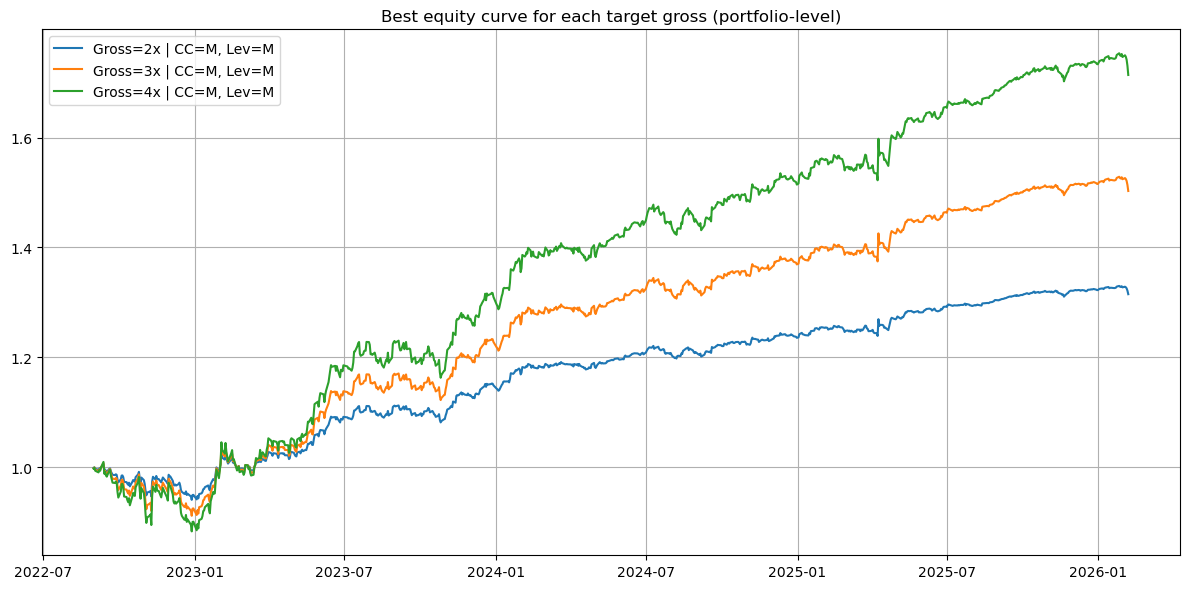

In [119]:
gross_levels = [2, 3, 4]

rets_bt = rets.loc[rets.index >= start_dt].copy()

cc_pairs  = list(ym_df[["Underlying","ETF"]].itertuples(index=False, name=None))
lev_pairs = list(dx_df[["Underlying","ETF"]].itertuples(index=False, name=None))

all_results = []
best_curves = {}   # (gross -> (label, curve))
best_rows   = []   # summary rows

for g in gross_levels:
    results = []
    curves  = {}

    for cc_f, lev_f in combos:
        port_ret, ret_cc, ret_lev, pc_cc, pc_lev = simulate_hybrid_realistic_with_drift(
            rets_bt,
            borrow_daily_map,
            cc_pairs,
            lev_pairs,
            cc_freq=cc_f,
            lev_freq=lev_f,
            sleeve_weight_mode="equal",
            target_gross_sleeve=float(g),   # <-- portfolio gross will be ~g if both sleeves same
            cap_drift=True,
            gross_cap_mult=10.0,
        )

        label = f"Gross={g}x | CC={cc_f}, Lev={lev_f}"
        s = perf_stats(port_ret, label)

        cc_stats  = summarize_pair_count(pc_cc, min_pairs=20, prefix="CC_")
        lev_stats = summarize_pair_count(pc_lev, min_pairs=20, prefix="Lev_")

        row = {"TargetGross": g, "CC_freq": cc_f, "Lev_freq": lev_f, **s, **cc_stats, **lev_stats}
        results.append(row)
        curves[label] = (1 + port_ret).cumprod()

    res_df = pd.DataFrame(results).sort_values("CAGR", ascending=False)
    all_results.append(res_df)

    # print table for this gross
    print(f"\n===== Target Gross (portfolio) ≈ {g}x =====")
    print(res_df[["TargetGross","CC_freq","Lev_freq","CAGR","Vol","MaxDD","TradingDays","Portfolio"]].to_string(index=False))

    # track best combo curve
    best = res_df.iloc[0].to_dict()
    best_rows.append({
        "TargetGross": g,
        "Best_CC": best["CC_freq"],
        "Best_Lev": best["Lev_freq"],
        "Best_CAGR": best["CAGR"],
        "Best_Vol": best["Vol"],
        "Best_MaxDD": best["MaxDD"],
        "TradingDays": best["TradingDays"],
    })

    # find best label
    best_label = f"Gross={g}x | CC={best['CC_freq']}, Lev={best['Lev_freq']}"
    best_curves[g] = (best_label, curves[best_label])

# Summary table: best per gross
best_df = pd.DataFrame(best_rows).sort_values("TargetGross")
print("\n===== Best combo by gross =====")
print(best_df.to_string(index=False))

# Plot: best equity curve per gross
plt.figure(figsize=(12, 6))
for g, (lbl, curve) in best_curves.items():
    plt.plot(curve.index, curve.values, label=lbl)
plt.title("Best equity curve for each target gross (portfolio-level)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [120]:
def compute_leg_stats(tr_price: pd.Series, trading_days: int = 252):
    """
    Given a total-return price series (long), compute stats and daily returns.
    Returns:
        stats: dict with cagr|, vol_annual, etc.
        ret:   daily simple returns (aligned with tr_price.index[1:])
    """
    tr_price = tr_price.dropna()
    if len(tr_price) < 3:
        return None, pd.Series(dtype=float)

    ret = tr_price.pct_change().dropna()
    T = len(ret)

    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1.0
    vol_annual = ret.std() * np.sqrt(trading_days)

    stats = {
        "cagr": cagr,
        "vol_annual": vol_annual,
        "n_obs": T,
    }
    return stats, ret

In [121]:
results_df = pd.DataFrame(results).sort_values("CAGR", ascending=False)

cols = [
    "CC_freq", "Lev_freq",
    "CAGR", "Vol", "MaxDD", "TradingDays",
    "CC_MinPairs", "CC_MaxPairs", "CC_AvgPairs", "CC_FirstDate_20pairs",
    "Lev_MinPairs", "Lev_MaxPairs", "Lev_AvgPairs", "Lev_FirstDate_20pairs",
]

print(results_df[cols].to_string(index=False))


CC_freq Lev_freq     CAGR      Vol     MaxDD  TradingDays  CC_MinPairs  CC_MaxPairs  CC_AvgPairs CC_FirstDate_20pairs  Lev_MinPairs  Lev_MaxPairs  Lev_AvgPairs Lev_FirstDate_20pairs
      M        M 0.170626 0.114675 -0.125321          862            8           33    18.752900  2024-08-30 04:00:00             2            56     18.618329   2024-10-31 04:00:00
      Q        M 0.167028 0.117235 -0.125397          862            7           33    18.147332  2024-09-30 04:00:00             2            56     18.618329   2024-10-31 04:00:00
  Never        M 0.166795 0.115313 -0.114183          862            6            6     6.000000                  NaT             2            56     18.618329   2024-10-31 04:00:00
      Q        Q 0.163824 0.118055 -0.102088          841            8           33    18.425684  2024-09-30 04:00:00             4            56     17.900119   2024-12-31 05:00:00
      W        W 0.161307 0.114270 -0.165875          875            7           33    18.

In [ ]:
# ============================================================
# END-TO-END SEGMENT:
# 1) Load ../config/all_pairs_with_betas.csv (or fallback paths)
# 2) Build TR price panel (Adj Close proxy) for all symbols
# 3) Run fixed-share, discrete rebalance backtest
#    - Equal-weight each pair
#    - Hedge ratio uses *Beta* from the CSV:
#         short_ETF_notional = long_underlying_notional / Beta
#      (with sane fallbacks if Beta is missing/invalid)
# ============================================================

import time
import numpy as np
import pandas as pd
import yfinance as yf
from pathlib import Path

TRADING_DAYS = 252
DEFAULT_BORROW_ANNUAL = 0.05

# -----------------------------
# Robust loader for all_pairs_with_betas.csv
# -----------------------------
def load_all_pairs_with_betas() -> pd.DataFrame:
    """
    Tries these locations in order:
      1) ../config/all_pairs_with_betas.csv  (relative to notebook/script)
      2) ./all_pairs_with_betas.csv          (cwd)
      3) /mnt/data/all_pairs_with_betas.csv  (this environment)
    """
    try:
        base = Path(__file__).resolve().parent
    except NameError:
        base = Path.cwd()

    candidates = [
        (base / ".." / "config" / "all_pairs_with_betas.csv").resolve(),
        (base / "all_pairs_with_betas.csv").resolve(),
        Path("/mnt/data/all_pairs_with_betas.csv"),
    ]

    path = next((p for p in candidates if p.exists()), None)
    if path is None:
        raise FileNotFoundError("Could not find all_pairs_with_betas.csv in ../config, cwd, or /mnt/data.")

    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]

    required = {"ETF", "Underlying", "Beta"}
    missing = required - set(df.columns)
    if missing:
        raise RuntimeError(f"Missing required columns {missing}. Found: {list(df.columns)}")

    # normalize tickers
    df["ETF"] = df["ETF"].astype(str).str.strip().str.replace(".", "-", regex=False).str.upper()
    df["Underlying"] = df["Underlying"].astype(str).str.strip().str.replace(".", "-", regex=False).str.upper()

    # numeric columns
    df["Beta"] = pd.to_numeric(df["Beta"], errors="coerce")
    if "Leverage" in df.columns:
        df["Leverage"] = pd.to_numeric(df["Leverage"], errors="coerce")
    else:
        df["Leverage"] = np.nan

    # drop junk
    df = df.dropna(subset=["ETF", "Underlying"])
    df = df[(df["ETF"] != "") & (df["Underlying"] != "")]
    df = df.drop_duplicates(subset=["ETF"]).reset_index(drop=True)

    return df


# -----------------------------
# TR loader (your robust yfinance adj-close proxy)
# -----------------------------
_TR_CACHE: dict[str, pd.Series] = {}

def get_total_return_series(
    sym: str,
    start: str = "2018-01-01",
    max_retries: int = 4,
    pause_s: float = 1.0,
) -> pd.Series:
    sym = str(sym).strip().upper().replace(".", "-")

    if sym in _TR_CACHE:
        return _TR_CACHE[sym]

    last_err = None
    for attempt in range(1, max_retries + 1):
        try:
            df = yf.download(
                sym,
                start=start,
                auto_adjust=False,
                progress=False,
                threads=False,
                timeout=30,
            )
            if df is None or df.empty:
                _TR_CACHE[sym] = pd.Series(dtype=float, name=sym)
                return _TR_CACHE[sym]

            col = "Adj Close" if "Adj Close" in df.columns else "Close"
            s = df[col].dropna().astype(float)
            if isinstance(s, pd.DataFrame):
                s = s.iloc[:, 0]
            s = s[~s.index.duplicated(keep="last")].sort_index()
            s.index = pd.to_datetime(s.index).tz_localize(None)

            _TR_CACHE[sym] = s.rename(sym)
            return _TR_CACHE[sym]

        except Exception as e:
            last_err = e
            time.sleep(pause_s * attempt)

    print(f"[WARN] yfinance failed for {sym} after {max_retries} retries: {last_err}")
    _TR_CACHE[sym] = pd.Series(dtype=float, name=sym)
    return _TR_CACHE[sym]


# -----------------------------
# Borrow helpers
# -----------------------------
def get_borrow_annual(sym: str) -> float:
    if "borrow_map" in globals() and borrow_map is not None:
        if sym in borrow_map:
            return float(borrow_map[sym])
        if "default" in borrow_map:
            return float(borrow_map["default"])
    return float(DEFAULT_BORROW_ANNUAL)

def make_borrow_daily_map(etfs: list[str]) -> dict[str, float]:
    return {etf: get_borrow_annual(etf) / TRADING_DAYS for etf in etfs}


# -----------------------------
# Rebalance calendar
# -----------------------------
def get_rebalance_days(index: pd.DatetimeIndex, freq: str) -> set[pd.Timestamp]:
    if len(index) == 0:
        return set()
    freq_u = str(freq).upper()
    idx = pd.DatetimeIndex(index)

    if freq_u in ("D", "DAILY"):
        return set(idx)

    if freq_u in ("W", "WEEKLY"):
        periods = idx.to_period("W-FRI")
    elif freq_u in ("M", "MONTHLY"):
        periods = idx.to_period("M")
    elif freq_u in ("Q", "QUARTERLY"):
        periods = idx.to_period("Q")
    else:
        raise ValueError(f"Unsupported freq: {freq}")

    s = pd.Series(idx, index=idx)
    last_by_period = s.groupby(periods).max().values
    return set(pd.to_datetime(last_by_period))


# -----------------------------
# Build TR prices for universe
# -----------------------------
def build_tr_prices_for_pairs(pairs_df: pd.DataFrame, start="2018-01-01"):
    # unique symbols to load
    syms = sorted(set(pairs_df["ETF"].tolist() + pairs_df["Underlying"].tolist()))

    series_list = []
    ok = set()

    for sym in syms:
        s = get_total_return_series(sym, start=start)
        if s is None or s.empty:
            print(f"WARNING: no TR data for {sym}; skipping.")
            continue
        series_list.append(s.rename(f"{sym}_TR"))
        ok.add(sym)

    if not series_list:
        raise RuntimeError("No symbols loaded from yfinance.")

    prices = pd.concat(series_list, axis=1).sort_index()

    # keep only pairs with both legs loaded
    ok_df = pairs_df[pairs_df["ETF"].isin(ok) & pairs_df["Underlying"].isin(ok)].copy()
    if ok_df.empty:
        raise RuntimeError("Loaded symbols but no complete pairs have both legs available.")

    print(f"Loaded symbols: {len(ok)} / {len(syms)}")
    print(f"Usable pairs: {len(ok_df)} / {len(pairs_df)}")

    return prices, ok_df.reset_index(drop=True)


# -----------------------------
# Core sim: equal-weight pairs, hedge by Beta
# -----------------------------
def simulate_equal_weight_beta_hedged(
    tr_prices: pd.DataFrame,
    pairs_df: pd.DataFrame,                 # columns: ETF, Underlying, Beta, (optional Leverage)
    borrow_daily_map: dict[str, float],
    freq: str = "W",
    backtest_start: str = "2023-01-01",
    target_gross_mult: float = 1.0,
    initial_equity: float = 1.0,
    short_history_beta_floor: float = 0.25, # avoid insane sizing if beta tiny
):
    px = tr_prices.loc[tr_prices.index >= pd.Timestamp(backtest_start)].copy()
    if px.empty:
        raise ValueError("No price data after backtest_start.")

    idx = px.index
    rebal_days = get_rebalance_days(idx, freq)

    # Precompute pair start dates: need first valid for both legs
    def first_valid(sym: str):
        col = f"{sym}_TR"
        return px[col].first_valid_index() if col in px.columns else None

    pair_start = {}
    for _, r in pairs_df.iterrows():
        und, etf = r["Underlying"], r["ETF"]
        d1, d2 = first_valid(und), first_valid(etf)
        if d1 is None or d2 is None:
            continue
        pair_start[(und, etf)] = max(pd.Timestamp(d1), pd.Timestamp(d2))

    equity = float(initial_equity)
    shares_under = pd.Series(dtype=float)
    shares_etf   = pd.Series(dtype=float)

    port_ret   = pd.Series(index=idx, dtype=float)
    pair_count = pd.Series(index=idx, dtype=int)

    def eligible_pairs_on(t):
        rows = []
        for _, r in pairs_df.iterrows():
            key = (r["Underlying"], r["ETF"])
            d0 = pair_start.get(key, None)
            if d0 is None or d0 > t:
                continue
            rows.append(r)
        return rows

    def choose_beta(row) -> float:
        b = float(row["Beta"]) if np.isfinite(row["Beta"]) else np.nan
        if np.isfinite(b) and abs(b) >= short_history_beta_floor:
            return b

        # fallback to Leverage if present
        lev = row.get("Leverage", np.nan)
        lev = float(lev) if np.isfinite(lev) else np.nan
        if np.isfinite(lev) and lev > 0:
            return lev

        # final fallback
        return 1.0

    def rebalance(t, active_rows):
        nonlocal shares_under, shares_etf
        n = len(active_rows)
        if n == 0:
            shares_under = pd.Series(dtype=float)
            shares_etf   = pd.Series(dtype=float)
            return

        long_u_dol = (target_gross_mult * equity) / n  # equal-weight pairs on long leg

        su, se = {}, {}
        for r in active_rows:
            und = r["Underlying"]
            etf = r["ETF"]
            b = choose_beta(r)

            und_col = f"{und}_TR"
            etf_col = f"{etf}_TR"
            if und_col not in px.columns or etf_col not in px.columns:
                continue

            pu = float(px.at[t, und_col])
            pe = float(px.at[t, etf_col])
            if not np.isfinite(pu) or pu <= 0 or not np.isfinite(pe) or pe <= 0:
                continue

            # hedge by beta: short_notional = long_notional / beta
            # use abs(beta) for sizing; sign is always "short ETF"
            short_e_dol = long_u_dol / max(abs(float(b)), short_history_beta_floor)

            su[und] = su.get(und, 0.0) + (long_u_dol / pu)
            se[etf] = se.get(etf, 0.0) - (short_e_dol / pe)

        shares_under = pd.Series(su, dtype=float)
        shares_etf   = pd.Series(se, dtype=float)

    prev_t = None
    for t in idx:
        if t in rebal_days:
            active = eligible_pairs_on(t)
            pair_count.at[t] = len(active)
            rebalance(t, active)
        else:
            pair_count.at[t] = 0 if prev_t is None else int(pair_count.at[prev_t])

        if shares_under.empty and shares_etf.empty:
            port_ret.at[t] = 0.0
            prev_t = t
            continue

        if prev_t is None:
            port_ret.at[t] = 0.0
            prev_t = t
            continue

        pnl = 0.0

        # Underlying PnL
        for und, sh in shares_under.items():
            col = f"{und}_TR"
            p0 = float(px.at[prev_t, col])
            p1 = float(px.at[t, col])
            if np.isfinite(p0) and np.isfinite(p1):
                pnl += float(sh) * (p1 - p0)

        # ETF PnL + borrow
        borrow_cost = 0.0
        for etf, sh in shares_etf.items():
            col = f"{etf}_TR"
            p0 = float(px.at[prev_t, col])
            p1 = float(px.at[t, col])
            if np.isfinite(p0) and np.isfinite(p1):
                pnl += float(sh) * (p1 - p0)

            bday = float(borrow_daily_map.get(etf, DEFAULT_BORROW_ANNUAL / TRADING_DAYS))
            if np.isfinite(p0):
                borrow_cost += abs(float(sh)) * p0 * bday

        pnl -= borrow_cost

        r = pnl / equity if equity != 0 else 0.0
        equity *= (1.0 + r)
        port_ret.at[t] = r
        prev_t = t

    return port_ret.dropna(), pair_count.dropna()


# -----------------------------
# Perf stats (quick)
# -----------------------------
def perf_stats(ret: pd.Series, label: str) -> dict:
    ret = ret.dropna()
    T = len(ret)
    if T == 0:
        return {"Portfolio": label, "TradingDays": 0, "CAGR": np.nan, "Vol": np.nan, "MaxDD": np.nan}
    curve = (1 + ret).cumprod()
    cagr = curve.iloc[-1] ** (TRADING_DAYS / T) - 1
    vol = ret.std(ddof=0) * np.sqrt(TRADING_DAYS)
    maxdd = (curve / curve.cummax() - 1).min()
    return {"Portfolio": label, "TradingDays": T, "CAGR": cagr, "Vol": vol, "MaxDD": maxdd}


# ============================================================
# RUN IT
# ============================================================

pairs_df = load_all_pairs_with_betas()

# Optional: if you only want a subset, filter here
# pairs_df = pairs_df[pairs_df["Leverage"] > 1.01].copy()   # example: only levered
# pairs_df = pairs_df[pairs_df["Leverage"] <= 1.01].copy()  # example: only income/cc

prices, pairs_ok = build_tr_prices_for_pairs(pairs_df, start="2018-01-01")

borrow_daily_map = make_borrow_daily_map(sorted(pairs_ok["ETF"].unique()))

port_ret, pair_count = simulate_equal_weight_beta_hedged(
    tr_prices=prices,
    pairs_df=pairs_ok,
    borrow_daily_map=borrow_daily_map,
    freq="W",                 # rebalance frequency
    backtest_start="2023-01-01",
    target_gross_mult=1.0,    # set 2.0/3.0/4.0 if you want more gross
)

print(perf_stats(port_ret, "Equal-weight pairs | beta-hedged"))
print("Avg active pairs:", float(pair_count.mean()))


Loaded symbols: 460 / 460
Usable pairs: 298 / 298
{'Portfolio': 'Equal-weight pairs | beta-hedged', 'TradingDays': 1133, 'CAGR': np.float64(0.214503252690053), 'Vol': np.float64(0.08648262534503702), 'MaxDD': np.float64(-0.059719186641824185)}
Avg active pairs: 90.02736098852604


In [ ]:
# ============================================================
# UPDATE: 80/20 bucket allocation by Beta threshold
# - 80% of equity allocated to pairs with |Beta| > 1.5
# - 20% allocated to the rest
# - Equal-weight pairs WITHIN each bucket
# - Hedge ratio uses Beta from CSV (same as before):
#       short_ETF_$ = long_underlying_$ / max(|beta_used|, beta_floor)
# ============================================================

import numpy as np
import pandas as pd
max_borrow_annual = .08
def simulate_equal_weight_beta_hedged_80_20(
    tr_prices: pd.DataFrame,
    pairs_df: pd.DataFrame,                 # columns: ETF, Underlying, Beta, optional Leverage
    borrow_daily_map: dict[str, float],
    freq: str = "W",
    backtest_start: str = "2023-01-01",
    target_gross_mult: float = 1.0,
    initial_equity: float = 1.0,
    beta_threshold: float = 1.5,            # bucket cut
    beta_floor: float = 0.25,               # sizing floor to avoid extreme leverage
    weight_high_beta: float = .8,         # 80% to |beta| > 1.5
):
    px = tr_prices.loc[tr_prices.index >= pd.Timestamp(backtest_start)].copy()
    if px.empty:
        raise ValueError("No price data after backtest_start.")

    idx = px.index
    rebal_days = get_rebalance_days(idx, freq)

    # Pair start dates: first date where both legs have prices
    def first_valid(sym: str):
        col = f"{sym}_TR"
        return px[col].first_valid_index() if col in px.columns else None

    pair_start = {}
    for _, r in pairs_df.iterrows():
        und, etf = r["Underlying"], r["ETF"]
        d1, d2 = first_valid(und), first_valid(etf)
        if d1 is None or d2 is None:
            continue
        pair_start[(und, etf)] = max(pd.Timestamp(d1), pd.Timestamp(d2))
        # Build banned set: ETFs whose borrow exceeds threshold
        # --- Borrow filter: exclude ETFs with annual borrow > max_borrow_annual ---
    banned_etfs = {
        etf for etf, bday in borrow_daily_map.items()
        if np.isfinite(bday) and float(bday) * TRADING_DAYS > max_borrow_annual
    }

    print(f"Excluded ETFs (borrow > {max_borrow_annual:.0%}): {len(banned_etfs)}")
    if banned_etfs:
        print("Sample excluded:", sorted(list(banned_etfs))[:25])

    # helper: choose beta with fallbacks (same spirit as your prior code)
    def choose_beta(row) -> float:
        b = float(row["Beta"]) if np.isfinite(row["Beta"]) else np.nan
        if np.isfinite(b) and abs(b) >= beta_floor:
            return b
        lev = row.get("Leverage", np.nan)
        lev = float(lev) if np.isfinite(lev) else np.nan
        if np.isfinite(lev) and lev > 0:
            return lev
        return 1.0

    equity = float(initial_equity)
    shares_under = pd.Series(dtype=float)
    shares_etf   = pd.Series(dtype=float)

    port_ret   = pd.Series(index=idx, dtype=float)
    pair_count = pd.Series(index=idx, dtype=int)

    def eligible_rows_on(t):
        rows = []
        for _, r in pairs_df.iterrows():
            etf = r["ETF"]
            if etf in banned_etfs:
                continue

            key = (r["Underlying"], r["ETF"])
            d0 = pair_start.get(key, None)
            if d0 is None or d0 > t:
                continue

            rows.append(r)
        return rows


    def rebalance(t, active_rows):
        nonlocal shares_under, shares_etf

        if len(active_rows) == 0:
            shares_under = pd.Series(dtype=float)
            shares_etf   = pd.Series(dtype=float)
            return

        # split into buckets using *raw CSV beta* (not the fallback beta)
        high = []
        low  = []
        for r in active_rows:
            b_raw = float(r["Beta"]) if np.isfinite(r["Beta"]) else np.nan
            if np.isfinite(b_raw) and abs(b_raw) > beta_threshold:
                high.append(r)
            else:
                low.append(r)

        # allocate equity budgets
        w_hi = float(weight_high_beta)
        w_lo = 1.0 - w_hi

        # If one bucket is empty, push 100% into the other (avoid idle cash)
        if len(high) == 0 and len(low) > 0:
            w_hi, w_lo = 0.0, 1.0
        elif len(low) == 0 and len(high) > 0:
            w_hi, w_lo = 1.0, 0.0

        budget_hi = target_gross_mult * equity * w_hi
        budget_lo = target_gross_mult * equity * w_lo

        long_hi = (budget_hi / len(high)) if len(high) > 0 else 0.0
        long_lo = (budget_lo / len(low))  if len(low)  > 0 else 0.0

        su, se = {}, {}

        def add_row(r, long_u_dol):
            und = r["Underlying"]
            etf = r["ETF"]
            b_used = choose_beta(r)

            und_col = f"{und}_TR"
            etf_col = f"{etf}_TR"
            if und_col not in px.columns or etf_col not in px.columns:
                return

            pu = float(px.at[t, und_col])
            pe = float(px.at[t, etf_col])
            if not np.isfinite(pu) or pu <= 0 or not np.isfinite(pe) or pe <= 0:
                return

            short_e_dol = long_u_dol / max(abs(float(b_used)), beta_floor)

            su[und] = su.get(und, 0.0) + (long_u_dol / pu)
            se[etf] = se.get(etf, 0.0) - (short_e_dol / pe)

        for r in high:
            add_row(r, long_hi)
        for r in low:
            add_row(r, long_lo)

        shares_under = pd.Series(su, dtype=float)
        shares_etf   = pd.Series(se, dtype=float)

    prev_t = None
    for t in idx:
        if t in rebal_days:
            active = eligible_rows_on(t)
            pair_count.at[t] = len(active)
            rebalance(t, active)
        else:
            pair_count.at[t] = 0 if prev_t is None else int(pair_count.at[prev_t])

        if shares_under.empty and shares_etf.empty:
            port_ret.at[t] = 0.0
            prev_t = t
            continue

        if prev_t is None:
            port_ret.at[t] = 0.0
            prev_t = t
            continue

        pnl = 0.0

        # underlying pnl
        for und, sh in shares_under.items():
            col = f"{und}_TR"
            p0 = float(px.at[prev_t, col])
            p1 = float(px.at[t, col])
            if np.isfinite(p0) and np.isfinite(p1):
                pnl += float(sh) * (p1 - p0)

        # etf pnl + borrow
        borrow_cost = 0.0
        for etf, sh in shares_etf.items():
            col = f"{etf}_TR"
            p0 = float(px.at[prev_t, col])
            p1 = float(px.at[t, col])
            if np.isfinite(p0) and np.isfinite(p1):
                pnl += float(sh) * (p1 - p0)

            bday = float(borrow_daily_map.get(etf, DEFAULT_BORROW_ANNUAL / TRADING_DAYS))
            if np.isfinite(p0):
                borrow_cost += abs(float(sh)) * p0 * bday

        pnl -= borrow_cost

        r = pnl / equity if equity != 0 else 0.0
        equity *= (1.0 + r)
        port_ret.at[t] = r
        prev_t = t

    return port_ret.dropna(), pair_count.dropna()


# ============================================================
# RUN (80/20 buckets)
# ============================================================
port_ret_80_20, pair_count_80_20 = simulate_equal_weight_beta_hedged_80_20(
    tr_prices=prices,
    pairs_df=pairs_ok,
    borrow_daily_map=borrow_daily_map,
    freq="W",
    backtest_start="2023-01-01",
    target_gross_mult=1.0,
    beta_threshold=1.5,
    beta_floor=0.25,
    weight_high_beta=1.0,
)

print(perf_stats(port_ret_80_20, "80/20 buckets | beta>1.5"))
print("Avg active pairs:", float(pair_count_80_20.mean()))


TypeError: unhashable type: 'list'

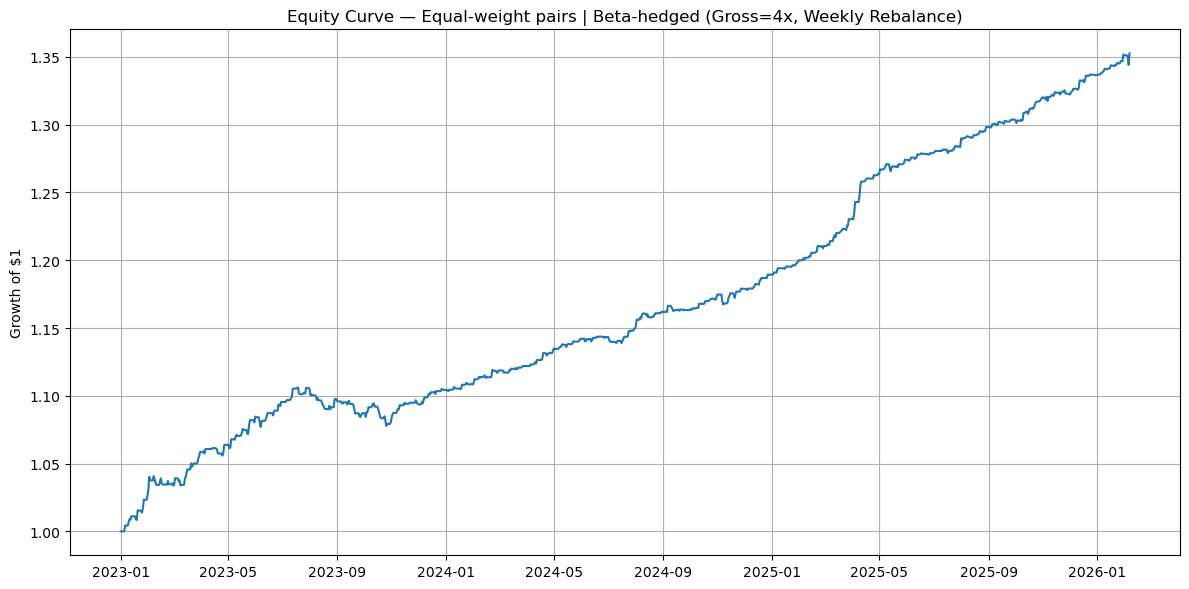

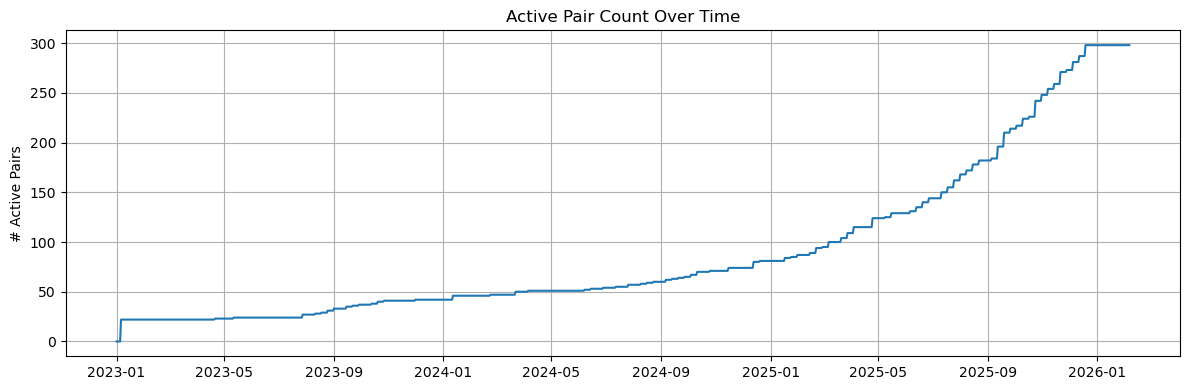

In [138]:
import matplotlib.pyplot as plt

# --- Equity curve (portfolio growth of $1) ---
equity_curve = (1 + port_ret_80_20.fillna(0)).cumprod()

plt.figure(figsize=(12,6))
plt.plot(equity_curve.index, equity_curve.values)
plt.title("Equity Curve — Equal-weight pairs | Beta-hedged (Gross=4x, Weekly Rebalance)")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Optional: active pair count over time ---
plt.figure(figsize=(12,4))
plt.plot(pair_count.index, pair_count.values)
plt.title("Active Pair Count Over Time")
plt.ylabel("# Active Pairs")
plt.grid(True)
plt.tight_layout()
plt.show()


===== Target Gross (per sleeve) = 4x equity =====
 TargetGross CC_freq Lev_freq     CAGR      Vol     MaxDD  TradingDays  NetLong_xEq_mean  Debit_xEq_mean  MarginInterest_total  BorrowCost_total
           4       M        W 0.333922 0.084968 -0.057453          757          1.330696        0.330696              0.056651          0.268496
           4       Q        W 0.306519 0.074637 -0.057453          715          1.330443        0.330443              0.054646          0.258714
           4       M        M 0.251054 0.095646 -0.057828          757          1.330798        0.330798              0.047781          0.230100
           4       Q        M 0.222101 0.087811 -0.057828          715          1.331508        0.331508              0.046054          0.221162

===== Target Gross (per sleeve) = 6x equity =====
 TargetGross CC_freq Lev_freq     CAGR      Vol     MaxDD  TradingDays  NetLong_xEq_mean  Debit_xEq_mean  MarginInterest_total  BorrowCost_total
           6       M        

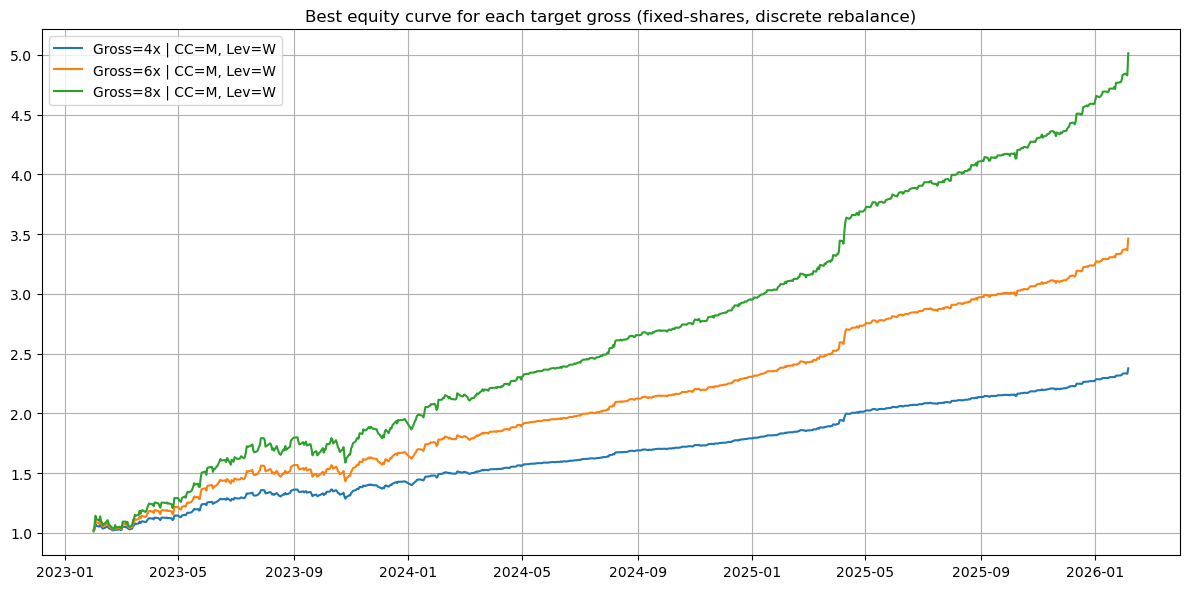

In [85]:
# =========================
# CONFIG (ADD / UPDATE)
# =========================
TRADING_DAYS = 252
DEFAULT_BORROW_ANNUAL = 0.05  # 5%

# NEW: Margin financing assumptions (IBKR-style daily accrual on debit)
MARGIN_ANNUAL   = 0.04428   # 4.428% blended
MARGIN_DAYCOUNT = 360       # IBKR-style Actual/360 convention for daily accrual

def simulate_sleeve_fixed_shares_rebalanced_to_gross(
    tr_prices: pd.DataFrame,
    pairs: list[tuple[str, str]],
    short_ratio: float,
    borrow_daily_map: dict[str, float],
    freq: str = "M",
    start_when_first_pair_active: bool = True,
    target_gross_mult: float = 4.0,
    initial_equity: float = 1.0,
    default_borrow_daily: float = DEFAULT_BORROW_ANNUAL / TRADING_DAYS,
    lock_universe_if_never: bool = True,
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
):
    px = tr_prices.copy()
    if px.index.tz is not None:
        px.index = px.index.tz_convert("UTC").tz_localize(None)

    idx = px.index
    rebal_days = get_rebalance_days(idx, freq)
    pair_start = build_pair_start_dates(px, pairs)

    equity = float(initial_equity)
    shares_under = pd.Series(dtype=float)
    shares_etf   = pd.Series(dtype=float)
    port_ret = pd.Series(index=idx, dtype=float)
    pair_count = pd.Series(index=idx, dtype=int)

    # NEW: diagnostics
    diag = pd.DataFrame(index=idx, columns=[
        "Equity",
        "LongNotional_prev",
        "ShortNotional_prev",
        "NetLong_prev",
        "Debit_prev",
        "MarginInterest",
        "BorrowCost",
    ], dtype=float)

    first_active_day = None
    locked_pairs = None

    def eligible_pairs_on(t):
        elig = []
        for (und, etf), d0 in pair_start.items():
            if d0 is None or d0 > t:
                continue
            elig.append((und, etf))
        return elig

    def rebalance_to_target_gross(t, active_pairs):
        nonlocal shares_under, shares_etf

        n = len(active_pairs)
        if n == 0:
            shares_under = pd.Series(dtype=float)
            shares_etf   = pd.Series(dtype=float)
            return

        gross_target = target_gross_mult * equity
        gross_per_pair = gross_target / n
        a = gross_per_pair / (1.0 + abs(short_ratio))

        su, se = {}, {}
        for und, etf in active_pairs:
            und_col = f"{und}_TR"
            etf_col = f"{etf}_TR"
            if und_col not in px.columns or etf_col not in px.columns:
                continue

            pu = float(px.at[t, und_col])
            pe = float(px.at[t, etf_col])
            if not np.isfinite(pu) or pu <= 0 or not np.isfinite(pe) or pe <= 0:
                continue

            long_u_dol  = a
            short_e_dol = a * abs(short_ratio)

            su[und] = su.get(und, 0.0) + (long_u_dol / pu)
            se[etf] = se.get(etf, 0.0) - (short_e_dol / pe)

        shares_under = pd.Series(su, dtype=float)
        shares_etf   = pd.Series(se, dtype=float)

    prev_t = None
    margin_daily = float(margin_annual) / float(margin_daycount)

    for t in idx:
        # rebalance logic (unchanged)
        if str(freq).upper() == "NEVER" and lock_universe_if_never:
            if locked_pairs is None:
                elig = eligible_pairs_on(t)
                if len(elig) > 0:
                    locked_pairs = elig
                    rebalance_to_target_gross(t, locked_pairs)
                    if first_active_day is None:
                        first_active_day = t
            pair_count.at[t] = 0 if locked_pairs is None else len(locked_pairs)
        else:
            if t in rebal_days:
                active_pairs = eligible_pairs_on(t)
                pair_count.at[t] = len(active_pairs)
                if first_active_day is None and len(active_pairs) > 0:
                    first_active_day = t
                rebalance_to_target_gross(t, active_pairs)
            else:
                pair_count.at[t] = 0 if prev_t is None else int(pair_count.at[prev_t])

        diag.at[t, "Equity"] = equity

        if shares_under.empty and shares_etf.empty:
            port_ret.at[t] = 0.0
            prev_t = t
            continue

        if prev_t is None:
            port_ret.at[t] = 0.0
            prev_t = t
            continue

        pnl = 0.0

        # PnL: underlyings
        for und, sh in shares_under.items():
            col = f"{und}_TR"
            if col not in px.columns:
                continue
            p0 = float(px.at[prev_t, col])
            p1 = float(px.at[t, col])
            if np.isfinite(p0) and np.isfinite(p1):
                pnl += float(sh) * (p1 - p0)

        # PnL: ETFs + borrow
        borrow_cost = 0.0
        for etf, sh in shares_etf.items():
            col = f"{etf}_TR"
            if col not in px.columns:
                continue
            p0 = float(px.at[prev_t, col])
            p1 = float(px.at[t, col])
            if np.isfinite(p0) and np.isfinite(p1):
                pnl += float(sh) * (p1 - p0)

            b = float(borrow_daily_map.get(etf, default_borrow_daily))
            if np.isfinite(p0):
                borrow_cost += abs(float(sh)) * p0 * b

        # NEW: notionals (prev day) + margin interest
        long_notional_prev = 0.0
        for und, sh in shares_under.items():
            col = f"{und}_TR"
            if col not in px.columns:
                continue
            p0 = float(px.at[prev_t, col])
            if np.isfinite(p0):
                long_notional_prev += float(sh) * p0

        short_notional_prev = 0.0
        for etf, sh in shares_etf.items():
            col = f"{etf}_TR"
            if col not in px.columns:
                continue
            p0 = float(px.at[prev_t, col])
            if np.isfinite(p0):
                short_notional_prev += abs(float(sh)) * p0

        net_long_prev = long_notional_prev - short_notional_prev
        debit_prev = max(0.0, net_long_prev - equity)
        margin_interest = debit_prev * margin_daily

        # store diagnostics
        diag.at[t, "LongNotional_prev"]  = long_notional_prev
        diag.at[t, "ShortNotional_prev"] = short_notional_prev
        diag.at[t, "NetLong_prev"]       = net_long_prev
        diag.at[t, "Debit_prev"]         = debit_prev
        diag.at[t, "MarginInterest"]     = margin_interest
        diag.at[t, "BorrowCost"]         = borrow_cost

        pnl -= (borrow_cost + margin_interest)

        r = pnl / equity if equity != 0 else 0.0
        equity *= (1.0 + r)
        port_ret.at[t] = r
        prev_t = t

    if start_when_first_pair_active and first_active_day is not None:
        port_ret = port_ret.loc[first_active_day:]
        pair_count = pair_count.loc[first_active_day:]
        diag = diag.loc[first_active_day:]

    return port_ret.dropna(), pair_count, diag

def simulate_hybrid_fixed_shares(
    tr_prices: pd.DataFrame,
    borrow_daily_map: dict[str, float],
    cc_pairs: list[tuple[str, str]],
    lev_pairs: list[tuple[str, str]],
    cc_freq: str = "M",
    lev_freq: str = "W",
    target_gross_mult_sleeve: float = 4.0,
    sleeve_mix: float = 0.5,
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
):
    ret_cc, pc_cc, diag_cc = simulate_sleeve_fixed_shares_rebalanced_to_gross(
        tr_prices, cc_pairs, short_ratio=CC_SHORT_RATIO,
        borrow_daily_map=borrow_daily_map, freq=cc_freq,
        target_gross_mult=target_gross_mult_sleeve,
        margin_annual=margin_annual, margin_daycount=margin_daycount,
    )

    ret_lev, pc_lev, diag_lev = simulate_sleeve_fixed_shares_rebalanced_to_gross(
        tr_prices, lev_pairs, short_ratio=LEV2_SHORT_RATIO,
        borrow_daily_map=borrow_daily_map, freq=lev_freq,
        target_gross_mult=target_gross_mult_sleeve,
        margin_annual=margin_annual, margin_daycount=margin_daycount,
    )

    common = ret_cc.index.intersection(ret_lev.index)
    if common.empty:
        raise ValueError("No overlapping dates between sleeves.")

    ret_cc = ret_cc.loc[common]
    ret_lev = ret_lev.loc[common]
    pc_cc = pc_cc.loc[common]
    pc_lev = pc_lev.loc[common]
    diag_cc = diag_cc.loc[common]
    diag_lev = diag_lev.loc[common]

    w = float(sleeve_mix)
    port_ret = w * ret_cc + (1.0 - w) * ret_lev

    # return both diags so grid can choose (you’re using sleeve_mix=0, so lev is what matters)
    return port_ret.dropna(), ret_cc, ret_lev, pc_cc, pc_lev, diag_cc, diag_lev

def run_grid_test(
    prices: pd.DataFrame,
    cc_pairs: list[tuple[str,str]],
    lev_pairs: list[tuple[str,str]],
    cc_freqs=("M",),
    lev_freqs=("W",),
    gross_levels=(2,3,4),
    backtest_start="2022-01-01",
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
):
    start_dt = pd.Timestamp(backtest_start)
    prices_bt = prices.loc[prices.index >= start_dt].copy()
    if prices_bt.empty:
        raise ValueError("No price data after backtest_start.")

    all_etfs = sorted(set([e for _, e in cc_pairs] + [e for _, e in lev_pairs]))
    borrow_daily_map = make_borrow_daily_map(all_etfs)

    all_results = []
    best_curves = {}
    best_rows = []

    combos = [(a,b) for a in cc_freqs for b in lev_freqs]

    for g in gross_levels:
        rows = []
        curves = {}

        for cc_f, lev_f in combos:
            port_ret, ret_cc, ret_lev, pc_cc, pc_lev, diag_cc, diag_lev = simulate_hybrid_fixed_shares(
                prices_bt, borrow_daily_map, cc_pairs, lev_pairs,
                cc_freq=cc_f, lev_freq=lev_f,
                target_gross_mult_sleeve=float(g),
                sleeve_mix=0.0,  # your case: 0% CC / 100% Lev
                margin_annual=margin_annual,
                margin_daycount=margin_daycount,
            )

            # choose which diag to report (since sleeve_mix=0, leveraged sleeve matters)
            diag_use = diag_lev.copy()

            # metrics (all in "per $1 equity" terms because sleeve initial_equity=1)
            # net long utilization as multiple of equity:
            net_long_mult_mean = float((diag_use["NetLong_prev"] / diag_use["Equity"]).dropna().mean())
            debit_mult_mean    = float((diag_use["Debit_prev"]   / diag_use["Equity"]).dropna().mean())

            total_margin_interest = float(diag_use["MarginInterest"].dropna().sum())
            total_borrow_cost     = float(diag_use["BorrowCost"].dropna().sum())

            label = f"Gross={g}x | CC={cc_f}, Lev={lev_f}"
            s = perf_stats(port_ret, label)
            cc_stats  = summarize_pair_count(pc_cc, min_pairs=20, prefix="CC_")
            lev_stats = summarize_pair_count(pc_lev, min_pairs=20, prefix="Lev_")

            rows.append({
                "TargetGross": g,
                "CC_freq": cc_f,
                "Lev_freq": lev_f,
                **s,
                **cc_stats,
                **lev_stats,

                # NEW reporting:
                "NetLong_xEq_mean": net_long_mult_mean,      # e.g. 2.00 means net long = 2x equity on avg
                "Debit_xEq_mean": debit_mult_mean,           # e.g. 1.00 means borrowing ~1x equity on avg
                "MarginInterest_total": total_margin_interest, # total paid over backtest (per $1 starting equity)
                "BorrowCost_total": total_borrow_cost,         # total borrow paid (per $1 starting equity)
            })

            curves[label] = (1 + port_ret).cumprod()

        res_df = pd.DataFrame(rows).sort_values("CAGR", ascending=False)
        all_results.append(res_df)

        print(f"\n===== Target Gross (per sleeve) = {g}x equity =====")
        cols = [
            "TargetGross","CC_freq","Lev_freq",
            "CAGR","Vol","MaxDD","TradingDays",
            "NetLong_xEq_mean","Debit_xEq_mean",
            "MarginInterest_total","BorrowCost_total",
        ]
        print(res_df[cols].to_string(index=False))

        best = res_df.iloc[0].to_dict()
        best_rows.append({
            "TargetGross": g,
            "Best_CC": best["CC_freq"],
            "Best_Lev": best["Lev_freq"],
            "Best_CAGR": best["CAGR"],
            "Best_Vol": best["Vol"],
            "Best_MaxDD": best["MaxDD"],
            "NetLong_xEq_mean": best["NetLong_xEq_mean"],
            "Debit_xEq_mean": best["Debit_xEq_mean"],
            "MarginInterest_total": best["MarginInterest_total"],
            "BorrowCost_total": best["BorrowCost_total"],
            "TradingDays": best["TradingDays"],
        })

        best_label = f"Gross={g}x | CC={best['CC_freq']}, Lev={best['Lev_freq']}"
        best_curves[g] = (best_label, curves[best_label])

    best_df = pd.DataFrame(best_rows).sort_values("TargetGross")
    print("\n===== Best combo by gross =====")
    print(best_df.to_string(index=False))

    plt.figure(figsize=(12,6))
    for g, (lbl, curve) in best_curves.items():
        plt.plot(curve.index, curve.values, label=lbl)
    plt.title("Best equity curve for each target gross (fixed-shares, discrete rebalance)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return all_results, best_df


# ============================================================
# MAIN (YOU RUN THIS) - call stays the same, but you CAN override margin here
# ============================================================
# prices, cc_pairs, lev_pairs = build_tr_prices_for_universe(dx_df, ym_df)

all_results, best_df = run_grid_test(
    prices,
    cc_pairs,
    lev_pairs,
    cc_freqs=("M","Q"),
    lev_freqs=("W","M"),
    gross_levels=[4, 6, 8],
    backtest_start="2023-01-01",
    margin_annual=0.04428,
    margin_daycount=360,
)


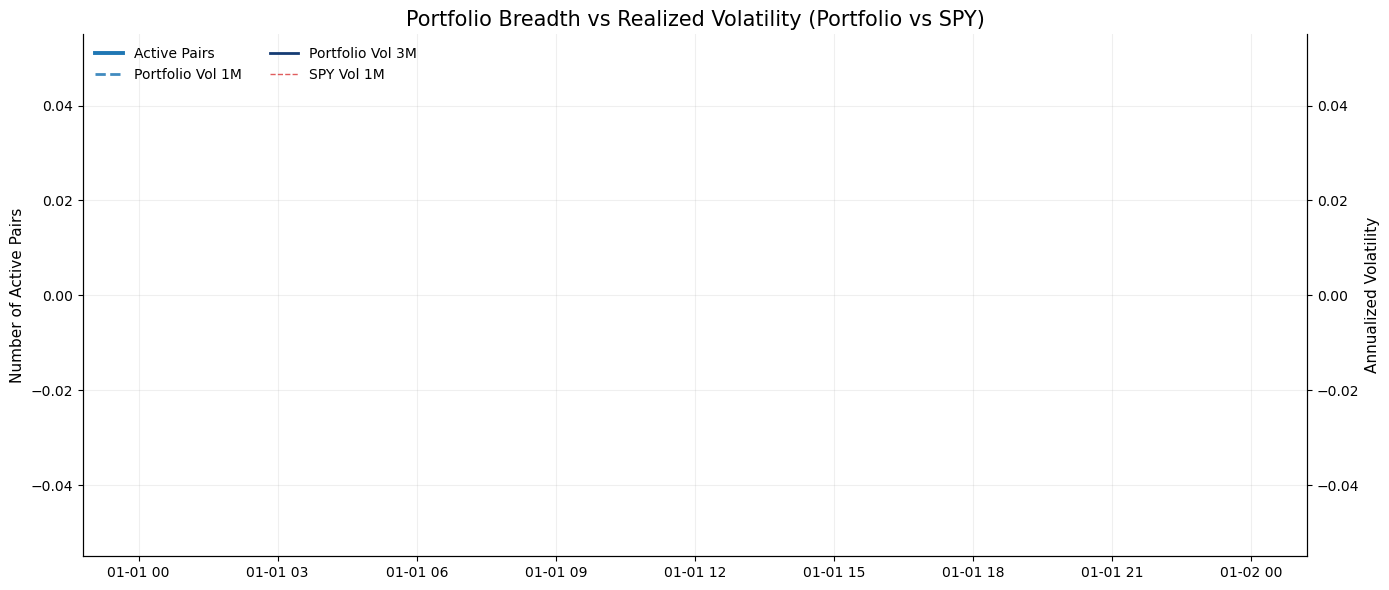

In [86]:
# Align everything
common = port_ret.index.intersection(pc_cc.index).intersection(pc_lev.index)

ret = port_ret.loc[common]
pairs_total = (pc_cc.loc[common] + pc_lev.loc[common]).astype(float)

TRADING_DAYS = 252

# --- SPY rolling vol ---
spy_px = get_total_return_series("SPY").dropna()
spy_ret = spy_px.pct_change().dropna()

# Align to portfolio index
common2 = ret.index.intersection(spy_ret.index)
ret_al  = ret.loc[common2]
pairs_al = pairs_total.loc[common2]
spy_ret_al = spy_ret.loc[common2]

# Recompute rolling vol on the aligned index (portfolio + SPY)
rolling_vol = pd.DataFrame(index=common2)
rolling_vol["Port_Vol_1m"] = ret_al.rolling(21).std()  * np.sqrt(TRADING_DAYS)
rolling_vol["Port_Vol_3m"] = ret_al.rolling(63).std()  * np.sqrt(TRADING_DAYS)
rolling_vol["Port_Vol_6m"] = ret_al.rolling(126).std() * np.sqrt(TRADING_DAYS)

rolling_vol["SPY_Vol_1m"]  = spy_ret_al.rolling(21).std()  * np.sqrt(TRADING_DAYS)
rolling_vol["SPY_Vol_3m"]  = spy_ret_al.rolling(63).std()  * np.sqrt(TRADING_DAYS)
rolling_vol["SPY_Vol_6m"]  = spy_ret_al.rolling(126).std() * np.sqrt(TRADING_DAYS)
plt.figure(figsize=(14,6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# --- Pair count (left axis)
ax1.plot(pairs_al.index, pairs_al.values, linewidth=2.8, label="Active Pairs")
ax1.set_ylabel("Number of Active Pairs", fontsize=11)

# --- Portfolio vol (right axis)
# --- Portfolio volatility (blues)
ax2.plot(
    rolling_vol.index,
    rolling_vol["Port_Vol_1m"],
    color="#1f77b4",        # deep blue
    linestyle="--",
    linewidth=2.0,
    alpha=0.85,
    label="Portfolio Vol 1M"
)

ax2.plot(
    rolling_vol.index,
    rolling_vol["Port_Vol_3m"],
    color="#08306b",        # darker blue
    linestyle="-",
    linewidth=2,
    alpha=0.95,
    label="Portfolio Vol 3M"
)

# --- SPY volatility (reds)
ax2.plot(
    rolling_vol.index,
    rolling_vol["SPY_Vol_1m"],
    color="#d62728",        # red
    linestyle="--",
    linewidth=1,
    alpha=0.75,
    label="SPY Vol 1M"
)



ax2.set_ylabel("Annualized Volatility", fontsize=11)

# --- Aesthetics
ax1.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax1.grid(True, alpha=0.2)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, frameon=False, loc="upper left", ncols=2)

plt.title("Portfolio Breadth vs Realized Volatility (Portfolio vs SPY)", fontsize=15)
plt.tight_layout()
plt.show()



=== Backtest Summary (Aligned daily returns) ===
                    Series      Start        End TargetGross CC_weight Lev_weight CC_freq Lev_freq AnnReturn AnnVol  MaxDD Sharpe Sortino NetLong_xEq_mean Debit_xEq_mean MarginInterest_total BorrowCost_total
Diamond Creek ETF Arb Fund 2023-01-31 2026-02-05        4.00      0.00       1.00       M        W     33.4%   8.5%  -5.7%   3.44    6.27             1.33           0.33                 5.7%            26.8%
                       SPY 2023-01-31 2026-02-05                                                       20.9%  15.2% -18.8%   1.32    1.98                                                                      


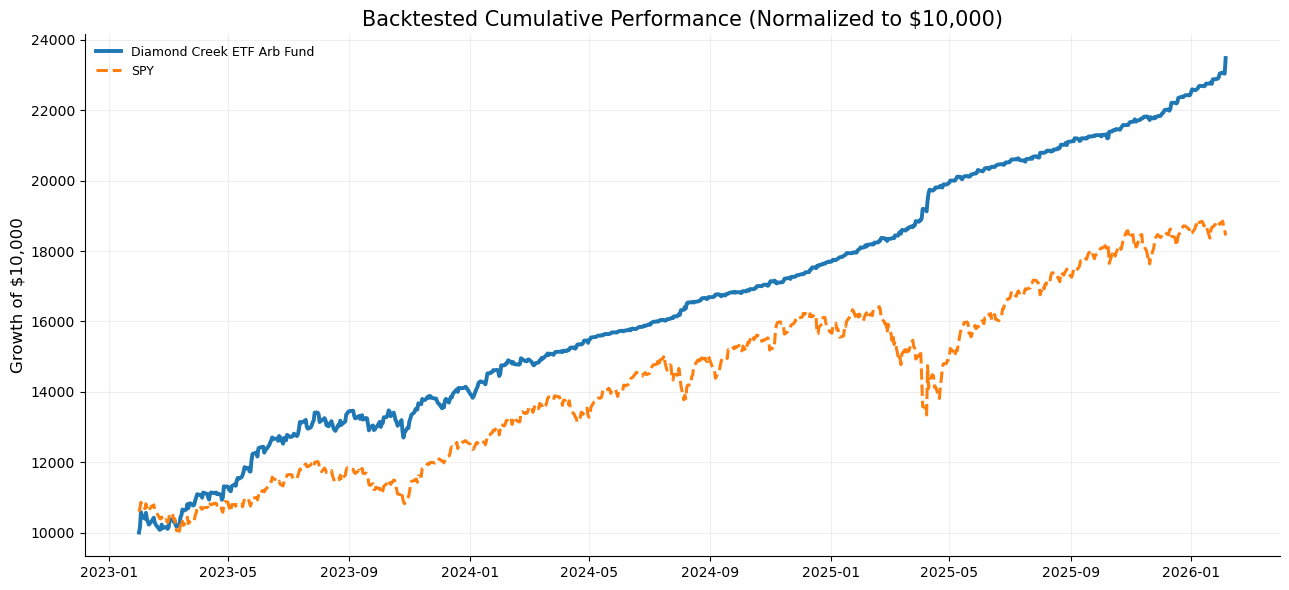

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

# -----------------------------
# Perf helpers
# -----------------------------
def max_drawdown_from_curve(curve: pd.Series) -> float:
    dd = curve / curve.cummax() - 1.0
    return float(dd.min())

def sharpe_ratio(ret: pd.Series, rf_annual: float = 0.00) -> float:
    ret = ret.dropna()
    if ret.empty:
        return np.nan
    rf_daily = (1.0 + rf_annual) ** (1.0 / TRADING_DAYS) - 1.0
    ex = ret - rf_daily
    vol = ex.std(ddof=0)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(ex.mean() / vol * np.sqrt(TRADING_DAYS))

def sortino_ratio(ret: pd.Series, rf_annual: float = 0.00, mar_annual: float | None = None) -> float:
    ret = ret.dropna()
    if ret.empty:
        return np.nan

    mar_annual = rf_annual if mar_annual is None else mar_annual
    mar_daily = (1.0 + mar_annual) ** (1.0 / TRADING_DAYS) - 1.0

    downside = (ret - mar_daily).clip(upper=0.0)
    downside_dev = np.sqrt((downside ** 2).mean())
    if downside_dev == 0 or np.isnan(downside_dev):
        return np.nan

    excess_mean_daily = (ret - mar_daily).mean()
    return float(excess_mean_daily / downside_dev * np.sqrt(TRADING_DAYS))

def perf_from_returns(ret: pd.Series, label: str, rf_annual: float = 0.00) -> dict:
    ret = ret.dropna()
    if ret.empty:
        return {
            "Series": label, "Start": None, "End": None,
            "AnnReturn": np.nan, "AnnVol": np.nan, "MaxDD": np.nan,
            "Sharpe": np.nan, "Sortino": np.nan
        }

    curve = (1.0 + ret).cumprod()
    T = len(ret)

    ann_return = float(curve.iloc[-1] ** (TRADING_DAYS / T) - 1.0)
    ann_vol = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    mdd = max_drawdown_from_curve(curve)

    sh = sharpe_ratio(ret, rf_annual=rf_annual)
    so = sortino_ratio(ret, rf_annual=rf_annual)

    return {
        "Series": label,
        "Start": ret.index.min().date(),
        "End": ret.index.max().date(),
        "AnnReturn": ann_return,
        "AnnVol": ann_vol,
        "MaxDD": mdd,
        "Sharpe": sh,
        "Sortino": so,
    }

def best_row_for_gross(all_results, target_gross: float, tol: float = 1e-6) -> pd.Series:
    candidates = []

    for res_df in all_results:
        if "TargetGross" not in res_df.columns:
            continue

        df = res_df.copy()
        tg = df["TargetGross"]

        if tg.dtype == object:
            tg_num = (
                tg.astype(str)
                  .str.replace("x", "", regex=False)
                  .str.strip()
            )
            tg_num = pd.to_numeric(tg_num, errors="coerce")
        else:
            tg_num = pd.to_numeric(tg, errors="coerce")

        df = df.assign(_tg_num=tg_num)
        m = np.isclose(df["_tg_num"].values, float(target_gross), atol=tol, rtol=0)
        if m.any():
            cand = df.loc[m].sort_values("CAGR", ascending=False).iloc[0]
            candidates.append(cand)

    if candidates:
        best = pd.DataFrame(candidates).sort_values("CAGR", ascending=False).iloc[0]
        return best

    all_rows = []
    for res_df in all_results:
        if "TargetGross" not in res_df.columns:
            continue
        df = res_df.copy()
        tg = df["TargetGross"]
        if tg.dtype == object:
            tg_num = (
                tg.astype(str)
                  .str.replace("x", "", regex=False)
                  .str.strip()
            )
            tg_num = pd.to_numeric(tg_num, errors="coerce")
        else:
            tg_num = pd.to_numeric(tg, errors="coerce")

        df["_tg_num"] = tg_num
        df = df.dropna(subset=["_tg_num", "CAGR"])
        all_rows.append(df)

    if not all_rows:
        raise ValueError("all_results has no usable TargetGross/CAGR rows.")

    big = pd.concat(all_rows, axis=0, ignore_index=True)
    big["dist"] = (big["_tg_num"] - float(target_gross)).abs()

    closest_gross = big.sort_values(["dist", "CAGR"], ascending=[True, False]).iloc[0]["_tg_num"]
    best = big.loc[big["_tg_num"] == closest_gross].sort_values("CAGR", ascending=False).iloc[0]

    print(
        f"WARNING: TargetGross={target_gross} not found in grid. "
        f"Falling back to closest gross={closest_gross} for CC_freq/Lev_freq selection, "
        f"but running simulation at TargetGross={target_gross}."
    )
    return best


# -----------------------------
# Run one configuration and return aligned returns + $10k curve + stats
# UPDATED for new simulate_hybrid_fixed_shares() return signature
# -----------------------------
def run_one_config(
    prices_bt: pd.DataFrame,
    cc_pairs,
    lev_pairs,
    all_results,
    target_gross: float,
    sleeve_mix: float,
    label: str,
    rf_annual: float = 0.00,

    # NEW: margin pass-through (optional)
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
):
    best = best_row_for_gross(all_results, target_gross=target_gross)
    cc_f = str(best["CC_freq"])
    lev_f = str(best["Lev_freq"])

    all_etfs = sorted(set([e for _, e in cc_pairs] + [e for _, e in lev_pairs]))
    borrow_daily_map = make_borrow_daily_map(all_etfs)

    # NEW return values: includes diag_cc, diag_lev
    port_ret, ret_cc, ret_lev, pc_cc, pc_lev, diag_cc, diag_lev = simulate_hybrid_fixed_shares(
        prices_bt,
        borrow_daily_map,
        cc_pairs,
        lev_pairs,
        cc_freq=cc_f,
        lev_freq=lev_f,
        target_gross_mult_sleeve=float(target_gross),
        sleeve_mix=float(sleeve_mix),
        margin_annual=float(margin_annual),
        margin_daycount=int(margin_daycount),
    )

    # Build $10k curve
    curve = (1.0 + port_ret.dropna()).cumprod()
    curve_10k = 10_000.0 * (curve / curve.iloc[0])

    stats = perf_from_returns(port_ret, label, rf_annual=rf_annual)
    stats["TargetGross"] = float(target_gross)
    stats["CC_weight"] = float(sleeve_mix)
    stats["Lev_weight"] = float(1.0 - sleeve_mix)
    stats["CC_freq"] = cc_f
    stats["Lev_freq"] = lev_f

    # Optional: add simple financing diagnostics (reported per $1 initial equity)
    # Choose the sleeve diagnostics that actually drives exposure given the mix:
    diag_use = diag_lev if float(sleeve_mix) <= 0.0 else diag_cc if float(sleeve_mix) >= 1.0 else None
    if diag_use is not None and "Equity" in diag_use.columns:
        net_long_mult_mean = float((diag_use["NetLong_prev"] / diag_use["Equity"]).dropna().mean())
        debit_mult_mean = float((diag_use["Debit_prev"] / diag_use["Equity"]).dropna().mean())
        total_margin_interest = float(diag_use["MarginInterest"].dropna().sum())
        total_borrow_cost = float(diag_use["BorrowCost"].dropna().sum())

        stats["NetLong_xEq_mean"] = net_long_mult_mean
        stats["Debit_xEq_mean"] = debit_mult_mean
        stats["MarginInterest_total"] = total_margin_interest
        stats["BorrowCost_total"] = total_borrow_cost
    else:
        stats["NetLong_xEq_mean"] = np.nan
        stats["Debit_xEq_mean"] = np.nan
        stats["MarginInterest_total"] = np.nan
        stats["BorrowCost_total"] = np.nan

    return port_ret, curve_10k, stats, diag_cc, diag_lev


# ============================================================
# MAIN
# ============================================================
START = pd.Timestamp("2023-01-01")
RF_ANNUAL = 0.00  # set to 0.04 if you want

# Restrict prices to backtest window
prices_bt = prices.loc[prices.index >= START].copy()

# SPY series (aligned later)
spy_px = get_total_return_series("SPY")
spy_px = spy_px.loc[START:].dropna()
spy_ret = spy_px.pct_change().dropna()
spy_curve = (1.0 + spy_ret).cumprod()
spy_curve_10k = 10_000.0 * (spy_curve / spy_curve.iloc[0])

# Desired configurations: (gross, cc_weight, label)
configs = [
    (4.0, 0.0, "Diamond Creek ETF Arb Fund"),
]

results = []
curves = {}
diag_store = {}  # optional: keep diags if you want to inspect

for gross, cc_w, label in configs:
    port_ret, curve_10k, stats, diag_cc, diag_lev = run_one_config(
        prices_bt=prices_bt,
        cc_pairs=cc_pairs,
        lev_pairs=lev_pairs,
        all_results=all_results,
        target_gross=gross,
        sleeve_mix=cc_w,
        label=label,
        rf_annual=RF_ANNUAL,
        margin_annual=MARGIN_ANNUAL,
        margin_daycount=MARGIN_DAYCOUNT,
    )
    results.append(stats)
    curves[label] = curve_10k
    diag_store[label] = {"cc": diag_cc, "lev": diag_lev}

# Align SPY to common curve index for reporting consistency:
common_idx = spy_ret.index
for s in curves.values():
    common_idx = common_idx.intersection(s.index)

spy_ret_aligned = spy_ret.loc[common_idx]
spy_stats = perf_from_returns(spy_ret_aligned, "SPY", rf_annual=RF_ANNUAL)
spy_stats["TargetGross"] = np.nan
spy_stats["CC_weight"] = np.nan
spy_stats["Lev_weight"] = np.nan
spy_stats["CC_freq"] = ""
spy_stats["Lev_freq"] = ""
spy_stats["NetLong_xEq_mean"] = np.nan
spy_stats["Debit_xEq_mean"] = np.nan
spy_stats["MarginInterest_total"] = np.nan
spy_stats["BorrowCost_total"] = np.nan
results.append(spy_stats)

# -----------------------------
# Summary table
# -----------------------------
stats_df = pd.DataFrame(results)

cols = [
    "Series", "Start", "End",
    "TargetGross", "CC_weight", "Lev_weight", "CC_freq", "Lev_freq",
    "AnnReturn", "AnnVol", "MaxDD", "Sharpe", "Sortino",
    # NEW optional diagnostics:
    "NetLong_xEq_mean", "Debit_xEq_mean", "MarginInterest_total", "BorrowCost_total",
]
stats_df = stats_df[cols]

# Format for printing
fmt = stats_df.copy()
for c in ["AnnReturn", "AnnVol", "MaxDD"]:
    fmt[c] = (fmt[c] * 100).map(lambda x: f"{x:,.1f}%" if pd.notna(x) else "")
for c in ["Sharpe", "Sortino"]:
    fmt[c] = fmt[c].map(lambda x: f"{x:,.2f}" if pd.notna(x) else "")
for c in ["TargetGross", "CC_weight", "Lev_weight", "NetLong_xEq_mean", "Debit_xEq_mean"]:
    fmt[c] = fmt[c].map(lambda x: f"{x:,.2f}" if pd.notna(x) else "")
for c in ["MarginInterest_total", "BorrowCost_total"]:
    # these are totals per $1 initial equity; show as %
    fmt[c] = (fmt[c] * 100).map(lambda x: f"{x:,.1f}%" if pd.notna(x) else "")

print("\n=== Backtest Summary (Aligned daily returns) ===")
print(fmt.to_string(index=False))

# -----------------------------
# Plot all curves normalized to $10,000
# -----------------------------
plt.figure(figsize=(13, 6))

for label, c10k in curves.items():
    c10k_aligned = c10k.loc[common_idx]
    plt.plot(c10k_aligned.index, c10k_aligned.values, linewidth=2.8, label=label)

spy_curve_10k_aligned = spy_curve_10k.loc[common_idx]
plt.plot(
    spy_curve_10k_aligned.index,
    spy_curve_10k_aligned.values,
    linewidth=2.2,
    linestyle="--",
    label="SPY",
)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, alpha=0.20)

plt.title("Backtested Cumulative Performance (Normalized to $10,000)", fontsize=15)
plt.ylabel("Growth of $10,000", fontsize=12)
plt.legend(frameon=False, fontsize=9, loc="upper left")
plt.tight_layout()
plt.show()



=== Backtest Summary (Gross vs Net-to-LPs) ===
                                         Series      Start        End TargetGross CC_weight Lev_weight CC_freq Lev_freq AnnReturn AnnVol  MaxDD Sharpe Sortino
Diamond Creek ETF Arb Fund (Gross of Fund Fees) 2023-02-01 2026-02-05        6.00      0.00       1.00       M        W     50.4%  12.7%  -8.7%   3.28    5.93
        Diamond Creek ETF Arb Fund (Net to LPs) 2023-02-01 2026-02-05        6.00      0.00       1.00       M        W     39.2%  13.1%  -9.2%   2.59    4.36
                                            SPY 2023-02-01 2026-02-05                                                       20.3%  15.2% -18.8%   1.29    1.93


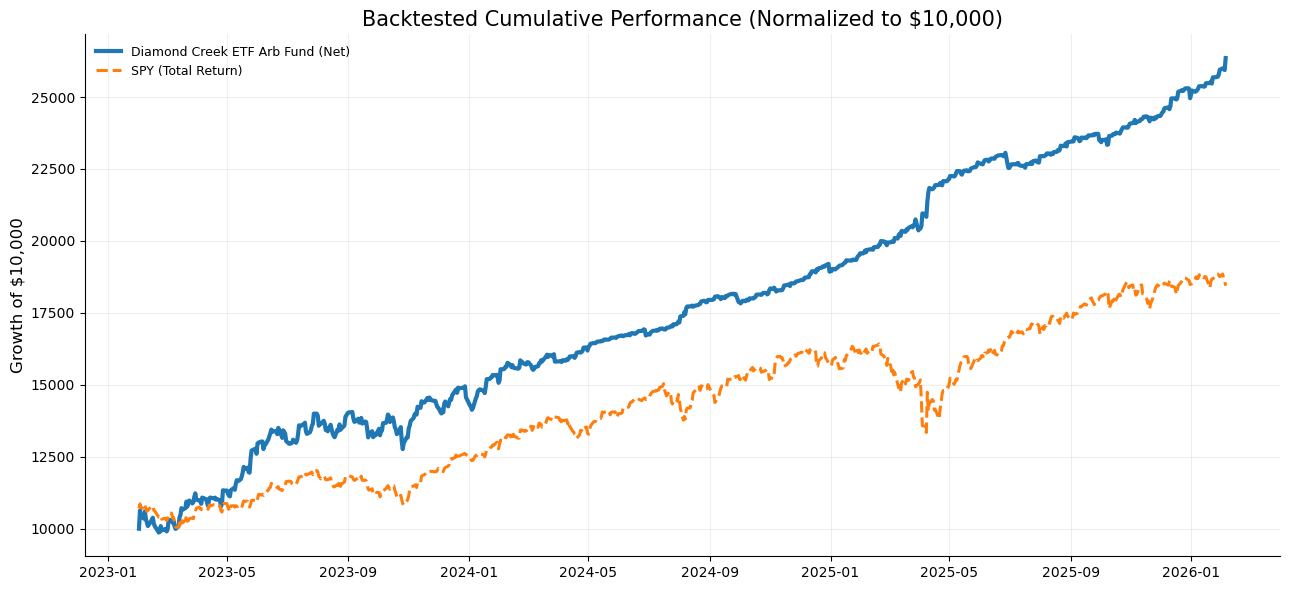

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

# ============================================================
# FUND FEE TERMS (LP-LEVEL)
# ============================================================
MGMT_FEE_ANNUAL = 0.02          # 2% per year
INCENTIVE_FEE = 0.20            # 20% performance allocation
HURDLE_ANNUAL = 0.10            # 10% annual hurdle
CRYSTALLIZE_FREQ = "Q"          # quarterly crystallization (and mgmt fee paid quarterly)

# Helpers: convert annual hurdle to per-quarter hurdle (compounded)
HURDLE_Q = (1.0 + HURDLE_ANNUAL) ** (1.0 / 4.0) - 1.0
MGMT_FEE_Q = MGMT_FEE_ANNUAL / 4.0  # simple quarterly charge (industry standard for mgmt fee)

# -----------------------------
# Perf helpers
# -----------------------------
def max_drawdown_from_curve(curve: pd.Series) -> float:
    dd = curve / curve.cummax() - 1.0
    return float(dd.min())

def sharpe_ratio(ret: pd.Series, rf_annual: float = 0.00) -> float:
    ret = ret.dropna()
    if ret.empty:
        return np.nan
    rf_daily = (1.0 + rf_annual) ** (1.0 / TRADING_DAYS) - 1.0
    ex = ret - rf_daily
    vol = ex.std(ddof=0)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return float(ex.mean() / vol * np.sqrt(TRADING_DAYS))

def sortino_ratio(ret: pd.Series, rf_annual: float = 0.00, mar_annual: float | None = None) -> float:
    ret = ret.dropna()
    if ret.empty:
        return np.nan

    mar_annual = rf_annual if mar_annual is None else mar_annual
    mar_daily = (1.0 + mar_annual) ** (1.0 / TRADING_DAYS) - 1.0

    downside = (ret - mar_daily).clip(upper=0.0)
    downside_dev = np.sqrt((downside ** 2).mean())
    if downside_dev == 0 or np.isnan(downside_dev):
        return np.nan

    excess_mean_daily = (ret - mar_daily).mean()
    return float(excess_mean_daily / downside_dev * np.sqrt(TRADING_DAYS))

def perf_from_returns(ret: pd.Series, label: str, rf_annual: float = 0.00) -> dict:
    ret = ret.dropna()
    if ret.empty:
        return {
            "Series": label, "Start": None, "End": None,
            "AnnReturn": np.nan, "AnnVol": np.nan, "MaxDD": np.nan,
            "Sharpe": np.nan, "Sortino": np.nan
        }

    curve = (1.0 + ret).cumprod()
    T = len(ret)

    ann_return = float(curve.iloc[-1] ** (TRADING_DAYS / T) - 1.0)
    ann_vol = float(ret.std(ddof=0) * np.sqrt(TRADING_DAYS))
    mdd = max_drawdown_from_curve(curve)

    sh = sharpe_ratio(ret, rf_annual=rf_annual)
    so = sortino_ratio(ret, rf_annual=rf_annual)

    return {
        "Series": label,
        "Start": ret.index.min().date(),
        "End": ret.index.max().date(),
        "AnnReturn": ann_return,
        "AnnVol": ann_vol,
        "MaxDD": mdd,
        "Sharpe": sh,
        "Sortino": so,
    }

# ============================================================
# NEW: LP FEE WRAPPER (Quarterly Mgmt + Quarterly Incentive, HWM, Hurdle, Full Catch-Up)
# ============================================================
def apply_lp_fees_quarterly(
    gross_daily_ret: pd.Series,
    mgmt_fee_q: float = MGMT_FEE_Q,
    incentive_fee: float = INCENTIVE_FEE,
    hurdle_q: float = HURDLE_Q,
    crystallize_freq: str = "Q",
) -> tuple[pd.Series, pd.DataFrame]:
    """
    Takes a daily return series (already net of trading/borrow/margin) and applies:
      - Management fee: 2%/yr paid quarterly (subtract mgmt_fee_q from NAV each quarter-end)
      - Incentive fee: 20% above quarterly hurdle, with full GP catch-up
      - High watermark (post-fee NAV)
    Crystallization: quarterly at period end.
    Returns:
      - net_daily_ret (LP net-of-fees daily returns, aligned to input index)
      - fee_diag (period-level diagnostics: gross, mgmt fee $, perf alloc $, HWM, etc.)
    """
    r = gross_daily_ret.replace([np.inf, -np.inf], np.nan).dropna().copy()
    if r.empty:
        return r, pd.DataFrame()

    idx = pd.DatetimeIndex(r.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)

    # Build NAV path with discrete fee events at quarter ends
    nav = 1.0
    hwm = 1.0
    nav_series = pd.Series(index=idx, dtype=float)

    # Diagnostics at crystallization points
    fee_rows = []

    # Define quarter-end dates present in the return index
    # Using period ends ensures robust handling even if not all calendar days exist.
    periods = idx.to_period("Q")
    # For each quarter, take the last trading day in that quarter available in idx
    quarter_ends = (
        pd.Series(idx, index=idx)
        .groupby(periods)
        .max()
        .sort_values()
        .to_list()
    )
    quarter_ends = set(pd.to_datetime(quarter_ends))

    # Track start NAV for hurdle computation within each quarter (post-fee start)
    q_start_nav = nav

    for t in idx:
        # daily compounding (gross of fund fees)
        nav *= (1.0 + float(r.loc[t]))
        nav_series.loc[t] = nav

        # crystallize at quarter end
        if t in quarter_ends:
            nav_pre_fees = nav

            # (1) Management fee charged on quarter-end NAV
            mgmt_fee_amt = mgmt_fee_q * nav_pre_fees
            nav_after_mgmt = nav_pre_fees - mgmt_fee_amt

            # (2) Incentive fee with HWM + hurdle + full catch-up
            perf_fee_amt = 0.0
            hurdle_nav = q_start_nav * (1.0 + hurdle_q)

            # Performance fees only if above BOTH:
            # - high watermark (post-fee)
            # - hurdle for the quarter
            if nav_after_mgmt > hwm and nav_after_mgmt > hurdle_nav:
                # Profits above hurdle, measured from quarter start NAV
                profit_over_hurdle = nav_after_mgmt - hurdle_nav  # dollars of NAV

                # With full catch-up:
                # - After hurdle, GP gets 100% until GP has 20% of total profits
                # - Equivalent closed form: GP allocation = carry * (nav_after_mgmt - hurdle_nav)
                #   when full catch-up is assumed and hurdle is a preferred return.
                # Note: This is the standard “preferred return + catch-up to carry” model.
                perf_fee_amt = incentive_fee * profit_over_hurdle
                nav_after_perf = nav_after_mgmt - perf_fee_amt

                # update HWM to post-fee NAV if it increased
                hwm = max(hwm, nav_after_perf)
                nav = nav_after_perf
            else:
                # no incentive fee; still update HWM if mgmt-fee NAV sets new HWM (rare)
                hwm = max(hwm, nav_after_mgmt)
                nav = nav_after_mgmt

            # record diag
            q_ret_gross = (nav_pre_fees / q_start_nav) - 1.0
            q_ret_net = (nav / q_start_nav) - 1.0

            fee_rows.append({
                "QuarterEnd": t,
                "StartNAV": q_start_nav,
                "EndNAV_preFees": nav_pre_fees,
                "MgmtFee_amt": mgmt_fee_amt,
                "EndNAV_postMgmt": nav_after_mgmt,
                "HurdleNAV": hurdle_nav,
                "PerfFee_amt": perf_fee_amt,
                "EndNAV_postFees": nav,
                "HWM_postFees": hwm,
                "QuarterGrossRet": q_ret_gross,
                "QuarterNetRet": q_ret_net,
            })

            # reset quarter start NAV after crystallization
            q_start_nav = nav

            # overwrite the NAV series at quarter end with post-fee NAV (so curve is post-fee)
            nav_series.loc[t] = nav

    # Convert NAV series to daily net returns (LP net-of-fees)
    nav_series = nav_series.dropna()
    net_daily_ret = nav_series.pct_change().dropna()
    net_daily_ret.name = "LP_NetRet"

    fee_diag = pd.DataFrame(fee_rows)
    if not fee_diag.empty:
        fee_diag["QuarterEnd"] = pd.to_datetime(fee_diag["QuarterEnd"])

    return net_daily_ret, fee_diag


# ============================================================
# Robust "best row for gross"
# ============================================================
def best_row_for_gross(all_results, target_gross: float, tol: float = 1e-6) -> pd.Series:
    candidates = []

    for res_df in all_results:
        if "TargetGross" not in res_df.columns:
            continue

        df = res_df.copy()
        tg = df["TargetGross"]

        if tg.dtype == object:
            tg_num = (
                tg.astype(str)
                  .str.replace("x", "", regex=False)
                  .str.strip()
            )
            tg_num = pd.to_numeric(tg_num, errors="coerce")
        else:
            tg_num = pd.to_numeric(tg, errors="coerce")

        df = df.assign(_tg_num=tg_num)
        m = np.isclose(df["_tg_num"].values, float(target_gross), atol=tol, rtol=0)
        if m.any():
            cand = df.loc[m].sort_values("CAGR", ascending=False).iloc[0]
            candidates.append(cand)

    if candidates:
        best = pd.DataFrame(candidates).sort_values("CAGR", ascending=False).iloc[0]
        return best

    all_rows = []
    for res_df in all_results:
        if "TargetGross" not in res_df.columns:
            continue
        df = res_df.copy()
        tg = df["TargetGross"]
        if tg.dtype == object:
            tg_num = (
                tg.astype(str)
                  .str.replace("x", "", regex=False)
                  .str.strip()
            )
            tg_num = pd.to_numeric(tg_num, errors="coerce")
        else:
            tg_num = pd.to_numeric(tg, errors="coerce")

        df["_tg_num"] = tg_num
        df = df.dropna(subset=["_tg_num", "CAGR"])
        all_rows.append(df)

    if not all_rows:
        raise ValueError("all_results has no usable TargetGross/CAGR rows.")

    big = pd.concat(all_rows, axis=0, ignore_index=True)
    big["dist"] = (big["_tg_num"] - float(target_gross)).abs()

    closest_gross = big.sort_values(["dist", "CAGR"], ascending=[True, False]).iloc[0]["_tg_num"]
    best = big.loc[big["_tg_num"] == closest_gross].sort_values("CAGR", ascending=False).iloc[0]

    print(
        f"WARNING: TargetGross={target_gross} not found in grid. "
        f"Falling back to closest gross={closest_gross} for CC_freq/Lev_freq selection, "
        f"but running simulation at TargetGross={target_gross}."
    )
    return best


# ============================================================
# Run one configuration and return:
# - gross (strategy) returns
# - LP net-of-fee returns (mgmt + incentive quarterly)
# - $10k curves for both
# - stats for both
# ============================================================
def run_one_config_with_fees(
    prices_bt: pd.DataFrame,
    cc_pairs,
    lev_pairs,
    all_results,
    target_gross: float,
    sleeve_mix: float,
    label: str,
    rf_annual: float = 0.00,
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
):
    best = best_row_for_gross(all_results, target_gross=target_gross)
    cc_f = str(best["CC_freq"])
    lev_f = str(best["Lev_freq"])

    all_etfs = sorted(set([e for _, e in cc_pairs] + [e for _, e in lev_pairs]))
    borrow_daily_map = make_borrow_daily_map(all_etfs)

    # strategy-level daily returns (already net of trading/borrow/margin from your simulator)
    port_ret_gross, ret_cc, ret_lev, pc_cc, pc_lev, diag_cc, diag_lev = simulate_hybrid_fixed_shares(
        prices_bt,
        borrow_daily_map,
        cc_pairs,
        lev_pairs,
        cc_freq=cc_f,
        lev_freq=lev_f,
        target_gross_mult_sleeve=float(target_gross),
        sleeve_mix=float(sleeve_mix),
        margin_annual=float(margin_annual),
        margin_daycount=int(margin_daycount),
    )

    # Apply LP fees quarterly
    port_ret_net, fee_diag = apply_lp_fees_quarterly(
        port_ret_gross,
        mgmt_fee_q=MGMT_FEE_Q,
        incentive_fee=INCENTIVE_FEE,
        hurdle_q=HURDLE_Q,
        crystallize_freq=CRYSTALLIZE_FREQ,
    )

    # Align net to gross index intersection for plotting/stats consistency
    common = port_ret_gross.index.intersection(port_ret_net.index)
    port_ret_gross = port_ret_gross.loc[common]
    port_ret_net = port_ret_net.loc[common]

    # Build $10k curves
    curve_gross = (1.0 + port_ret_gross).cumprod()
    curve_net = (1.0 + port_ret_net).cumprod()

    curve_gross_10k = 10_000.0 * (curve_gross / curve_gross.iloc[0])
    curve_net_10k = 10_000.0 * (curve_net / curve_net.iloc[0])

    # Stats
    stats_gross = perf_from_returns(port_ret_gross, f"{label} (Gross of Fund Fees)", rf_annual=rf_annual)
    stats_net = perf_from_returns(port_ret_net, f"{label} (Net to LPs)", rf_annual=rf_annual)

    # add config meta
    for st in (stats_gross, stats_net):
        st["TargetGross"] = float(target_gross)
        st["CC_weight"] = float(sleeve_mix)
        st["Lev_weight"] = float(1.0 - sleeve_mix)
        st["CC_freq"] = cc_f
        st["Lev_freq"] = lev_f

    return {
        "ret_gross": port_ret_gross,
        "ret_net": port_ret_net,
        "curve_gross_10k": curve_gross_10k,
        "curve_net_10k": curve_net_10k,
        "stats_gross": stats_gross,
        "stats_net": stats_net,
        "fee_diag": fee_diag,
        "diag_cc": diag_cc,
        "diag_lev": diag_lev,
    }


# ============================================================
# MAIN
# ============================================================
START = pd.Timestamp("2023-01-01")
RF_ANNUAL = 0.00

prices_bt = prices.loc[prices.index >= START].copy()

# SPY
spy_px = get_total_return_series("SPY")
spy_px = spy_px.loc[START:].dropna()
spy_ret = spy_px.pct_change().dropna()
spy_curve = (1.0 + spy_ret).cumprod()
spy_curve_10k = 10_000.0 * (spy_curve / spy_curve.iloc[0])

# Configs (you can add more)
configs = [
    (6.0, 0.0, "Diamond Creek ETF Arb Fund"),
]

results = []
curves = {}

for gross, cc_w, label in configs:
    out = run_one_config_with_fees(
        prices_bt=prices_bt,
        cc_pairs=cc_pairs,
        lev_pairs=lev_pairs,
        all_results=all_results,
        target_gross=gross,
        sleeve_mix=cc_w,
        label=label,
        rf_annual=RF_ANNUAL,
        margin_annual=MARGIN_ANNUAL,
        margin_daycount=MARGIN_DAYCOUNT,
    )

    # store stats rows
    results.append(out["stats_gross"])
    results.append(out["stats_net"])

    # store curves (plot both)
    #curves[f"{label} (Gross of Fund Fees)"] = out["curve_gross_10k"]
    curves[f"{label} (Net)"] = out["curve_net_10k"]

# Align SPY with all curves
common_idx = spy_ret.index
for s in curves.values():
    common_idx = common_idx.intersection(s.index)

spy_ret_aligned = spy_ret.loc[common_idx]
spy_stats = perf_from_returns(spy_ret_aligned, "SPY", rf_annual=RF_ANNUAL)
spy_stats["TargetGross"] = np.nan
spy_stats["CC_weight"] = np.nan
spy_stats["Lev_weight"] = np.nan
spy_stats["CC_freq"] = ""
spy_stats["Lev_freq"] = ""
results.append(spy_stats)

# -----------------------------
# Summary table
# -----------------------------
stats_df = pd.DataFrame(results)

cols = [
    "Series", "Start", "End",
    "TargetGross", "CC_weight", "Lev_weight", "CC_freq", "Lev_freq",
    "AnnReturn", "AnnVol", "MaxDD", "Sharpe", "Sortino",
]
stats_df = stats_df[cols]

fmt = stats_df.copy()
for c in ["AnnReturn", "AnnVol", "MaxDD"]:
    fmt[c] = (fmt[c] * 100).map(lambda x: f"{x:,.1f}%" if pd.notna(x) else "")
for c in ["Sharpe", "Sortino"]:
    fmt[c] = fmt[c].map(lambda x: f"{x:,.2f}" if pd.notna(x) else "")
for c in ["TargetGross", "CC_weight", "Lev_weight"]:
    fmt[c] = fmt[c].map(lambda x: f"{x:,.2f}" if pd.notna(x) else "")

print("\n=== Backtest Summary (Gross vs Net-to-LPs) ===")
print(fmt.to_string(index=False))

# -----------------------------
# Plot curves normalized to $10,000
# -----------------------------
plt.figure(figsize=(13, 6))

for label, c10k in curves.items():
    c10k_aligned = c10k.loc[common_idx]
    plt.plot(c10k_aligned.index, c10k_aligned.values, linewidth=3, label=label)

spy_curve_10k_aligned = spy_curve_10k.loc[common_idx]
plt.plot(
    spy_curve_10k_aligned.index,
    spy_curve_10k_aligned.values,
    linewidth=2.2,
    linestyle="--",
    label="SPY (Total Return)",
)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, alpha=0.20)

plt.title("Backtested Cumulative Performance (Normalized to $10,000)", fontsize=15)
plt.ylabel("Growth of $10,000", fontsize=12)
plt.legend(frameon=False, fontsize=9, loc="upper left")
plt.tight_layout()
plt.show()

# -----------------------------
# Optional: show fee diagnostics (quarterly)
# -----------------------------
# If you want a quick view of fees paid:
# print(out["fee_diag"].tail(12).to_string(index=False))
# print("Total mgmt fees (% of start NAV):", out["fee_diag"]["MgmtFee_amt"].sum())
# print("Total incentive fees (% of start NAV):", out["fee_diag"]["PerfFee_amt"].sum())


In [89]:
import numpy as np
import pandas as pd

# ============================================================
# Quarterly returns table (same as before)
# ============================================================

def quarterly_return_table(daily_ret: pd.Series) -> pd.DataFrame:
    r = daily_ret.dropna().copy()
    r.index = pd.to_datetime(r.index)
    r = r.sort_index()

    q_ret = (1.0 + r).resample("Q").prod() - 1.0

    rows = []
    for y in sorted(q_ret.index.year.unique()):
        qy = q_ret[q_ret.index.year == y]
        out = {"Year": y, "Q1": np.nan, "Q2": np.nan, "Q3": np.nan, "Q4": np.nan, "FY / YTD": np.nan}

        for ts, val in qy.items():
            q = pd.Timestamp(ts).quarter
            out[f"Q{q}"] = float(val)

        out["FY / YTD"] = float((1.0 + qy).prod() - 1.0) if len(qy) > 0 else np.nan
        rows.append(out)

    df = pd.DataFrame(rows).set_index("Year")
    return df.loc[df.notna().any(axis=1)]

def format_pct_table(df: pd.DataFrame) -> pd.DataFrame:
    def fmt(x):
        if pd.isna(x):
            return ""
        return f"({abs(x)*100:.1f}%)" if x < 0 else f"{x*100:.1f}%"
    return df.applymap(fmt)


# ============================================================
# FIXED fee model (prevents "fee spill" into next year)
#
# Mechanics:
# 1) Build NAV from gross daily returns
# 2) Apply management fee daily to NAV
# 3) At each calendar YEAR-END date that exists in the series:
#    - compute that year's return (after mgmt)
#    - incentive fee = 20% * max(year_return - 10%, 0)
#    - apply the fee ON THE YEAR-END DATE by scaling NAV from that date forward
#
# Key fix vs your version:
# - The performance fee is realized on the LAST DATE OF THE YEAR in your data,
#   not on the first day of the following year (which was making 2026 look too low).
#
# Optional:
# - crystallize_final_partial_year=False by default (so you don't take a partial-year
#   incentive fee at the end of the backtest).
# ============================================================

def gross_to_net_daily_returns(
    gross_daily_ret: pd.Series,
    mgmt_fee_annual: float = 0.02,
    perf_fee: float = 0.20,
    hurdle_annual: float = 0.10,
    trading_days: int = 252,
    crystallize_final_partial_year: bool = False,
) -> pd.Series:
    r = gross_daily_ret.dropna().copy()
    r.index = pd.to_datetime(r.index)
    r = r.sort_index()

    # 1) Gross NAV
    nav_gross = (1.0 + r).cumprod()

    # 2) Apply management fee daily (simple daily accrual on NAV)
    mgmt_fee_daily = mgmt_fee_annual / trading_days
    mgmt_multiplier = (1.0 - mgmt_fee_daily) ** np.arange(len(nav_gross))
    nav_after_mgmt = nav_gross * mgmt_multiplier
    nav_after_mgmt = nav_after_mgmt.astype(float)

    # 3) Apply incentive fees at year-end dates (scale NAV from year-end forward)
    nav_net = nav_after_mgmt.copy()

    years = sorted(nav_net.index.year.unique())
    for i, y in enumerate(years):
        year_mask = nav_net.index.year == y
        year_idx = nav_net.index[year_mask]
        if len(year_idx) < 2:
            continue

        year_start = year_idx[0]
        year_end = year_idx[-1]

        # If it's the final year and we don't want partial-year crystallization, skip.
        is_final_year = (y == years[-1])
        if is_final_year and (not crystallize_final_partial_year):
            continue

        year_ret = (nav_net.loc[year_end] / nav_net.loc[year_start]) - 1.0
        perf_base = max(year_ret - hurdle_annual, 0.0)
        perf_charge = perf_fee * perf_base  # fraction of year-start NAV

        if perf_charge > 0:
            # Apply the fee ON the year-end date (affects year-end daily return, not next year)
            scale = (1.0 - perf_charge)
            nav_net.loc[year_end:] = nav_net.loc[year_end:] * scale

    # Convert NAV back to daily returns
    net_daily_ret = nav_net.pct_change().dropna()
    return net_daily_ret


# ============================================================
# Build BOTH tables (gross + net)
# Assumes you already have: port_ret (gross daily returns)
# ============================================================

q_table_gross = quarterly_return_table(port_ret)
q_table_gross_fmt = format_pct_table(q_table_gross)

port_ret_net = gross_to_net_daily_returns(
    port_ret,
    mgmt_fee_annual=0.02,
    perf_fee=0.20,
    hurdle_annual=0.10,
    trading_days=252,
    crystallize_final_partial_year=False,  # IMPORTANT: avoids extra fee drag in 2026 YTD
)

q_table_net = quarterly_return_table(port_ret_net)
q_table_net_fmt = format_pct_table(q_table_net)

print("\n=== Quarterly Net Performance (GROSS of fees) ===")
print(q_table_gross_fmt.to_string())

print("\n=== Quarterly Net Performance (NET to LPs, 2/20 w/ 10% hurdle) ===")
print(q_table_net_fmt.to_string())



=== Quarterly Net Performance (GROSS of fees) ===
         Q1     Q2    Q3    Q4 FY / YTD
Year                                   
2023  12.2%  15.2%  1.8%  8.4%    42.7%
2024   7.3%   5.0%  6.0%  5.1%    25.4%
2025   6.5%   9.0%  3.8%  5.3%    26.8%
2026   4.7%                        4.7%

=== Quarterly Net Performance (NET to LPs, 2/20 w/ 10% hurdle) ===
         Q1     Q2    Q3    Q4 FY / YTD
Year                                   
2023  10.5%  14.6%  1.3%  1.7%    30.6%
2024   6.8%   4.4%  5.4%  1.5%    19.3%
2025   6.0%   8.4%  3.2%  1.8%    20.8%
2026   4.5%                        4.5%


In [97]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression

TRADING_DAYS = 252
BENCH_1 = ["SPY"]
BENCH_4 = ["SPY", "AGG", "HYG", "DBC"]

# ----------------------------
# Helpers: index normalization
# ----------------------------
def _to_date_index(s: pd.Series) -> pd.Series:
    s = s.copy()
    idx = pd.to_datetime(s.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_convert("UTC").tz_localize(None)
    idx = idx.normalize()
    s.index = idx
    s = s[~s.index.duplicated(keep="last")]
    return s

def load_adjclose_returns(ticker: str, start: str) -> pd.Series:
    df = yf.download(
        ticker, start=start,
        auto_adjust=False, progress=False, threads=False, timeout=30
    )
    if df is None or df.empty:
        return pd.Series(dtype=float, name=ticker)

    col = "Adj Close" if "Adj Close" in df.columns else "Close"
    px = df[col]
    if isinstance(px, pd.DataFrame):
        px = px.iloc[:, 0]
    px = px.dropna().astype(float)
    px.index = pd.to_datetime(px.index).tz_localize(None)

    ret = px.pct_change().dropna()
    ret.name = ticker
    return _to_date_index(ret)

# ----------------------------
# Regression (sklearn)
# ----------------------------
def regress_r2(port_ret: pd.Series, bench: list[str], min_obs: int = 50):
    y = port_ret.replace([np.inf, -np.inf], np.nan).dropna()
    if y.empty:
        raise ValueError("port_ret is empty after dropping NaN/inf.")
    y.name = "PORT"
    y = _to_date_index(y)

    start = str(y.index.min().date())
    X = pd.concat([load_adjclose_returns(t, start=start) for t in bench], axis=1)

    df = pd.concat([y, X], axis=1).dropna()
    if len(df) < min_obs:
        raise ValueError(f"Not enough overlapping observations after alignment: {len(df)}")

    yv = df["PORT"].to_numpy()
    Xv = df[bench].to_numpy()

    lr = LinearRegression(fit_intercept=True)
    lr.fit(Xv, yv)

    r2 = float(lr.score(Xv, yv))
    alpha_daily = float(lr.intercept_)
    betas = pd.Series(lr.coef_, index=bench)

    return {
        "n_obs": int(len(df)),
        "r2": r2,
        "alpha_daily": alpha_daily,
        "alpha_ann": float((1.0 + alpha_daily) ** TRADING_DAYS - 1.0),
        "betas": betas,
    }

# ----------------------------
# Robust "best row for gross" (handles 4 vs 4.0 vs "4x"; falls back to closest)
# ----------------------------
def _coerce_targetgross_to_numeric(s: pd.Series) -> pd.Series:
    if s.dtype == object:
        out = (
            s.astype(str)
             .str.replace("x", "", regex=False)
             .str.strip()
        )
        return pd.to_numeric(out, errors="coerce")
    return pd.to_numeric(s, errors="coerce")

def best_row_for_gross(all_results, target_gross: float, tol: float = 1e-8) -> pd.Series:
    rows = []
    for df in all_results:
        if "TargetGross" not in df.columns:
            continue
        d = df.copy()
        d["_tg"] = _coerce_targetgross_to_numeric(d["TargetGross"])
        d = d.dropna(subset=["_tg", "CAGR"])
        rows.append(d)

    if not rows:
        raise ValueError("all_results has no usable TargetGross/CAGR rows.")

    res_all = pd.concat(rows, ignore_index=True)

    m = np.isclose(res_all["_tg"].to_numpy(), float(target_gross), atol=tol, rtol=0)
    if m.any():
        best = res_all.loc[m].sort_values("CAGR", ascending=False).iloc[0]
        return best

    # fallback: closest gross available
    res_all["dist"] = (res_all["_tg"] - float(target_gross)).abs()
    closest = float(res_all.sort_values(["dist", "CAGR"], ascending=[True, False]).iloc[0]["_tg"])
    best = res_all.loc[res_all["_tg"] == closest].sort_values("CAGR", ascending=False).iloc[0]

    return best

# ----------------------------
# Run a config -> port_ret
# UPDATED for new simulate_hybrid_fixed_shares() return signature (adds diag_cc, diag_lev)
# AND passes margin params through
# ----------------------------
def run_portfolio_returns_for_config(
    prices_bt: pd.DataFrame,
    cc_pairs,
    lev_pairs,
    all_results,
    target_gross: float,
    sleeve_mix: float,
    margin_annual: float = MARGIN_ANNUAL,
    margin_daycount: int = MARGIN_DAYCOUNT,
):
    best = best_row_for_gross(all_results, target_gross=target_gross)
    best_cc = str(best["CC_freq"])
    best_lev = str(best["Lev_freq"])

    borrow_daily_map = make_borrow_daily_map(
        sorted(set([e for _, e in cc_pairs] + [e for _, e in lev_pairs]))
    )

    # NEW: simulate_hybrid_fixed_shares returns 7 values now
    port_ret, ret_cc, ret_lev, pc_cc, pc_lev, diag_cc, diag_lev = simulate_hybrid_fixed_shares(
        prices_bt,
        borrow_daily_map,
        cc_pairs, lev_pairs,
        cc_freq=best_cc,
        lev_freq=best_lev,
        target_gross_mult_sleeve=float(target_gross),
        sleeve_mix=float(sleeve_mix),
        margin_annual=float(margin_annual),
        margin_daycount=int(margin_daycount),
    )

    meta = {
        "TargetGross": float(target_gross),
        "sleeve_mix": float(sleeve_mix),
        "CC_freq": best_cc,
        "Lev_freq": best_lev,
        "grid_CAGR": float(best["CAGR"]),
    }
    return port_ret, meta, diag_cc, diag_lev

# ============================================================
# Run the configs + regressions
# ============================================================
START = pd.Timestamp("2023-01-01")
prices_bt = prices.loc[prices.index >= START].copy()

configs = [
    #(4.0, 0.50, "4.0x gross | 50/50 (CC/Lev)"),
    #(2.5, 0.20, "2.5x gross | 20/80 (CC/Lev)"),
    (4.0, 0.00, "4.0x gross | 0/100 (CC/Lev)"),
]

rows = []

for gross, mix, label in configs:
    port_ret, meta, diag_cc, diag_lev = run_portfolio_returns_for_config(
        prices_bt=prices_bt,
        cc_pairs=cc_pairs,
        lev_pairs=lev_pairs,
        all_results=all_results,
        target_gross=gross,
        sleeve_mix=mix,
        margin_annual=MARGIN_ANNUAL,
        margin_daycount=MARGIN_DAYCOUNT,
    )

    out1 = regress_r2(port_ret, BENCH_1)
    out4 = regress_r2(port_ret, BENCH_4)

    # Optional: include financing diagnostics in the output table (per $1 initial equity)
    # (for mix=0, leveraged sleeve diag is the relevant one)
    diag_use = diag_lev if float(mix) <= 0.0 else diag_cc if float(mix) >= 1.0 else None
    if diag_use is not None and "Equity" in diag_use.columns:
        net_long_mult_mean = float((diag_use["NetLong_prev"] / diag_use["Equity"]).dropna().mean())
        debit_mult_mean = float((diag_use["Debit_prev"] / diag_use["Equity"]).dropna().mean())
        total_margin_interest = float(diag_use["MarginInterest"].dropna().sum())
        total_borrow_cost = float(diag_use["BorrowCost"].dropna().sum())
    else:
        net_long_mult_mean = np.nan
        debit_mult_mean = np.nan
        total_margin_interest = np.nan
        total_borrow_cost = np.nan

    row = {
        "Config": label,
        "TargetGross": meta["TargetGross"],
        "CC_weight": meta["sleeve_mix"],
        "Lev_weight": 1.0 - meta["sleeve_mix"],
        "CC_freq": meta["CC_freq"],
        "Lev_freq": meta["Lev_freq"],
        "n_obs": out1["n_obs"],

        # SPY only
        "R2_SPY": out1["r2"],
        "beta_SPY": float(out1["betas"].loc["SPY"]),
        "alpha_ann_SPY": out1["alpha_ann"],

        # NEW optional:
        "NetLong_xEq_mean": net_long_mult_mean,
        "Debit_xEq_mean": debit_mult_mean,
        "MarginInterest_total": total_margin_interest,
        "BorrowCost_total": total_borrow_cost,
    }
    rows.append(row)

out_df = pd.DataFrame(rows)

# Pretty print
pretty = out_df.copy()
for c in ["R2_SPY"]:
    pretty[c] = pretty[c].map(lambda x: f"{x:.3f}")
for c in ["beta_SPY"]:
    pretty[c] = pretty[c].map(lambda x: f"{x:.3f}")
for c in ["alpha_ann_SPY"]:
    pretty[c] = pretty[c].map(lambda x: f"{x*100:+.2f}%")

for c in ["NetLong_xEq_mean", "Debit_xEq_mean"]:
    pretty[c] = pretty[c].map(lambda x: f"{x:.2f}" if pd.notna(x) else "")
for c in ["MarginInterest_total", "BorrowCost_total"]:
    pretty[c] = pretty[c].map(lambda x: f"{x*100:.1f}%" if pd.notna(x) else "")

print("\n=== R² / Beta Summary ===")
print(pretty[[
    "Config", "TargetGross", "CC_weight", "Lev_weight", "CC_freq", "Lev_freq",
    "n_obs",
    "R2_SPY", "beta_SPY", "alpha_ann_SPY",
    "NetLong_xEq_mean", "Debit_xEq_mean", "MarginInterest_total", "BorrowCost_total",
]].to_string(index=False))



=== R² / Beta Summary ===
                     Config  TargetGross  CC_weight  Lev_weight CC_freq Lev_freq  n_obs R2_SPY beta_SPY alpha_ann_SPY NetLong_xEq_mean Debit_xEq_mean MarginInterest_total BorrowCost_total
4.0x gross | 0/100 (CC/Lev)          4.0        0.0         1.0       M        W    756  0.136    0.206       +28.12%             1.33           0.33                 5.7%            26.8%


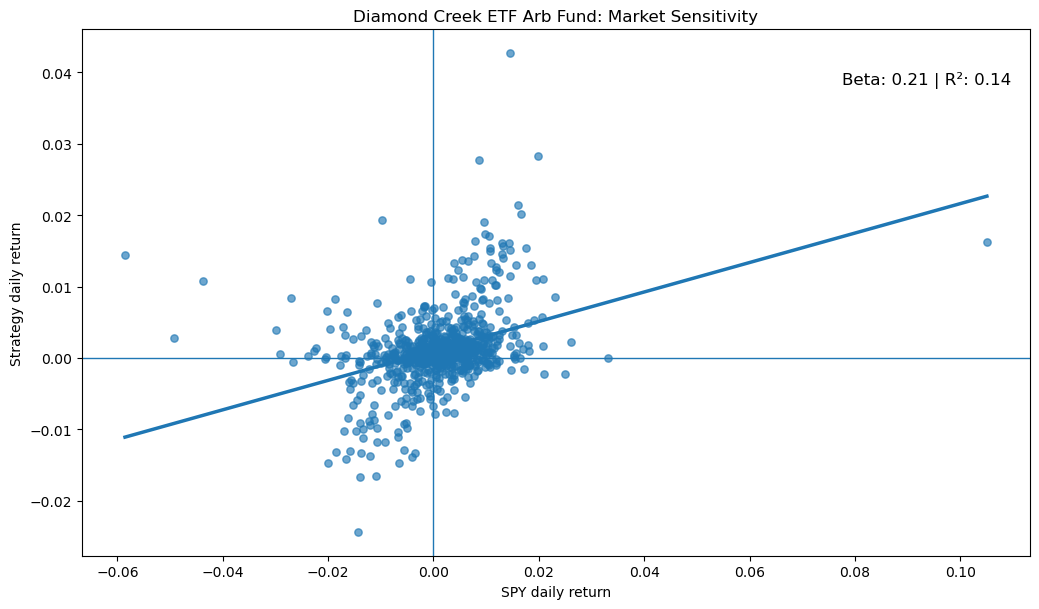

{'beta': 0.2063277395275817, 'r2': 0.1361817998913677, 'n_obs': 756}


In [99]:
# ============================================
# Scatter: Strategy daily returns vs SPY daily returns
# + regression line
# + show Beta and R^2 on chart
# (matches the style of your example image)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

TRADING_DAYS = 252

def plot_spy_scatter_with_beta_r2(port_ret: pd.Series, start: str | None = None, title: str = "Diamond Creek ETF Arb Fund: Market Sensitivity"):
    """
    port_ret: daily strategy returns (pd.Series indexed by date)
    start: optional YYYY-MM-DD to trim the plot/regression window
    """
    # --- load SPY daily returns aligned to port_ret dates (uses your helper)
    y = port_ret.replace([np.inf, -np.inf], np.nan).dropna()
    if start is not None:
        y = y.loc[pd.Timestamp(start):]
    y = _to_date_index(y)

    spy = load_adjclose_returns("SPY", start=str(y.index.min().date()))
    spy = _to_date_index(spy)

    df = pd.concat([spy.rename("SPY"), y.rename("STRAT")], axis=1).dropna()
    if len(df) < 50:
        raise ValueError(f"Not enough overlapping observations: {len(df)}")

    X = df[["SPY"]].to_numpy()
    Y = df["STRAT"].to_numpy()

    lr = LinearRegression(fit_intercept=True)
    lr.fit(X, Y)

    beta = float(lr.coef_[0])
    r2 = float(lr.score(X, Y))

    # --- line for plotting
    x_line = np.linspace(df["SPY"].min(), df["SPY"].max(), 200).reshape(-1, 1)
    y_line = lr.predict(x_line)

    # --- plot (style matches screenshot: points, fit line, crosshairs)
    plt.figure(figsize=(10.5, 6.2))
    plt.scatter(df["SPY"], df["STRAT"], alpha=0.65, s=28)
    plt.plot(x_line.flatten(), y_line, linewidth=2.5)

    plt.axhline(0, linewidth=1)
    plt.axvline(0, linewidth=1)

    plt.title(title)
    plt.xlabel("SPY daily return")
    plt.ylabel("Strategy daily return")

    # place text in upper-right like your image
    plt.text(
        0.98, 0.92,
        f"Beta: {beta:.2f} | R²: {r2:.2f}",
        transform=plt.gca().transAxes,
        ha="right", va="top",
        fontsize=12
    )

    plt.tight_layout()
    plt.show()

    return {"beta": beta, "r2": r2, "n_obs": len(df)}

# ============================================
# Example usage (plug in your port_ret from the loop)
# ============================================
#port_ret, meta, diag_cc, diag_lev = run_portfolio_returns_for_config(...)
stats = plot_spy_scatter_with_beta_r2(port_ret, start="2023-01-01",
                                     title="Diamond Creek ETF Arb Fund: Market Sensitivity")
print(stats)


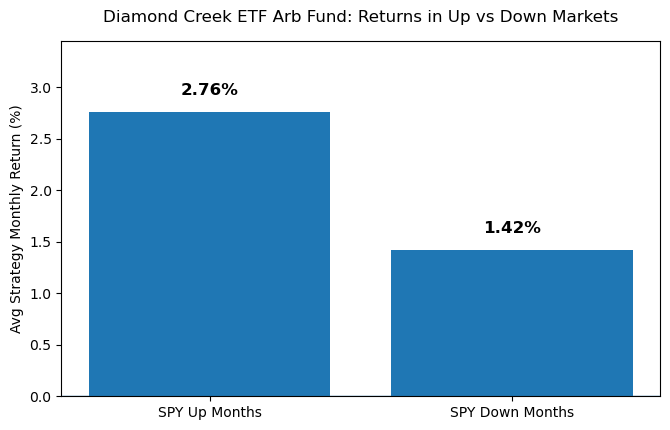

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_up_down_markets(
    port_ret: pd.Series,
    spy_ret: pd.Series,
    title: str = "Diamond Creek ETF Arb Fund: Returns in Up vs Down Markets",
    savepath: str | None = None,
):
    port_ret = port_ret.replace([np.inf, -np.inf], np.nan).dropna()
    spy_ret  = spy_ret.replace([np.inf, -np.inf], np.nan).dropna()

    port_ret.index = pd.to_datetime(port_ret.index).tz_localize(None)
    spy_ret.index  = pd.to_datetime(spy_ret.index).tz_localize(None)

    df = pd.concat([port_ret.rename("PORT"), spy_ret.rename("SPY")], axis=1).dropna()

    m = (1.0 + df).resample("M").prod() - 1.0
    m = m.dropna()

    up_mask = m["SPY"] > 0
    down_mask = m["SPY"] <= 0

    avg_up = m.loc[up_mask, "PORT"].mean() * 100
    avg_down = m.loc[down_mask, "PORT"].mean() * 100

    counts = [int(up_mask.sum()), int(down_mask.sum())]
    labels = ["SPY Up Months", "SPY Down Months"]
    values = [avg_up, avg_down]

    # --- plot ---
    fig, ax = plt.subplots(figsize=(6.8, 4.4))
    bars = ax.bar(labels, values)

    ax.set_title(title, pad=14)  # move title up a bit
    ax.set_ylabel("Avg Strategy Monthly Return (%)")
    ax.axhline(0, linewidth=1)
    ax.grid(False)

    # --- reserve headroom so labels NEVER hit the title ---
    vmax = max(values) if len(values) else 0
    ax.set_ylim(0, vmax * 1.25)  # <-- the key fix (25% headroom)

    # offsets as a fraction of y-range (scales nicely)
    y0, y1 = ax.get_ylim()
    yr = y1 - y0
    off_pct = 0.04 * yr   # percent label offset
    off_n   = 0.015 * yr  # n label offset

    for bar, val, n in zip(bars, values, counts):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()

        ax.text(
            x, y + off_pct,
            f"{val:.2f}%",
            ha="center", va="bottom",
            fontsize=12, fontweight="semibold"
        )


    fig.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")

    plt.show()


spy_ret = load_adjclose_returns(
    "SPY",
    start=str(port_ret.index.min().date())
)

plot_up_down_markets(
    port_ret,
    spy_ret,
    savepath="returns_up_vs_down.png"
)


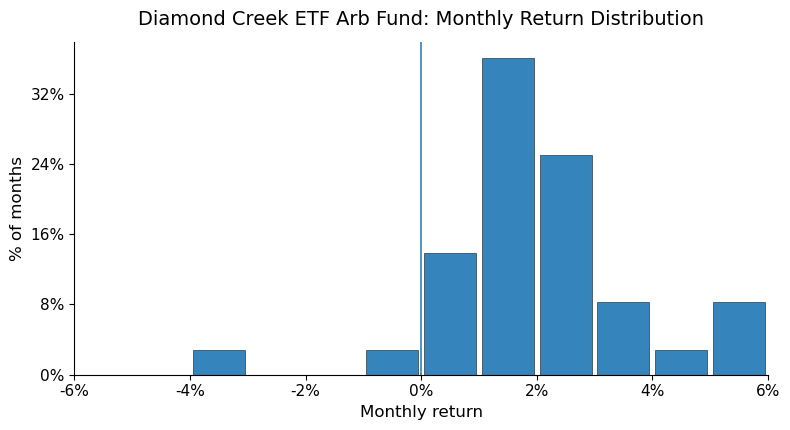

{'n_months': 38, 'mean_monthly': 0.023257675904041396, 'median_monthly': 0.019278238539153114, 'pct_positive_months': 0.9473684210526315, 'worst_month': -0.031427377436092474, 'best_month': 0.09115331050986186}


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

def plot_monthly_return_distribution_clean(
    port_ret_daily: pd.Series,
    title: str = "Diamond Creek ETF Arb Fund: Monthly Return Distribution",
    bin_width: float = 0.01,        # 1% buckets
    xlim: float = 0.06,             # show +/-6% only (clean & concise)
    show_mean: bool = False,
    savepath: str | None = None,
):
    # --- clean daily returns ---
    r = port_ret_daily.replace([np.inf, -np.inf], np.nan).dropna()
    r.index = pd.to_datetime(r.index).tz_localize(None)

    # --- monthly compounded returns ---
    monthly = (1.0 + r).resample("M").prod() - 1.0
    monthly = monthly.dropna()

    # --- clip ONLY for display ---
    monthly_plot = monthly[np.abs(monthly) <= xlim]

    # --- bins ---
    bins = np.arange(-xlim, xlim + bin_width, bin_width)
    counts, edges = np.histogram(monthly_plot, bins=bins)
    pct = counts / counts.sum() * 100
    centers = 0.5 * (edges[:-1] + edges[1:])

    # --- formatters ---
    pct_fmt = FuncFormatter(lambda y, _: f"{y:.0f}%")
    ret_fmt = FuncFormatter(lambda x, _: f"{100*x:.0f}%")

    # --- plot ---
    fig, ax = plt.subplots(figsize=(8.0, 4.4))

    ax.bar(
        centers,
        pct,
        width=bin_width * 0.9,
        edgecolor="black",
        linewidth=0.4,
        alpha=0.9
    )

    # zero line
    ax.axvline(0, linewidth=1.1)

    # optional mean
    if show_mean:
        ax.axvline(monthly.mean(), linestyle="--", linewidth=1)

    # labels
    ax.set_title(title, fontsize=14, pad=12)
    ax.set_xlabel("Monthly return", fontsize=12)
    ax.set_ylabel("% of months", fontsize=12)

    # axis formatting
    ax.set_xlim(-xlim, xlim)
    ax.xaxis.set_major_formatter(ret_fmt)
    ax.yaxis.set_major_formatter(pct_fmt)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=6))
    ax.tick_params(axis="both", labelsize=11)

    # clean frame
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(False)

    fig.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")

    plt.show()

    return {
        "n_months": int(len(monthly)),
        "mean_monthly": float(monthly.mean()),
        "median_monthly": float(monthly.median()),
        "pct_positive_months": float((monthly > 0).mean()),
        "worst_month": float(monthly.min()),
        "best_month": float(monthly.max()),
    }

stats = plot_monthly_return_distribution_clean(
    port_ret,
    bin_width=0.01,   # 1% buckets
    xlim=0.06,        # +/-6% keeps it tight and honest
    savepath="monthly_return_distribution.png"
)
print(stats)


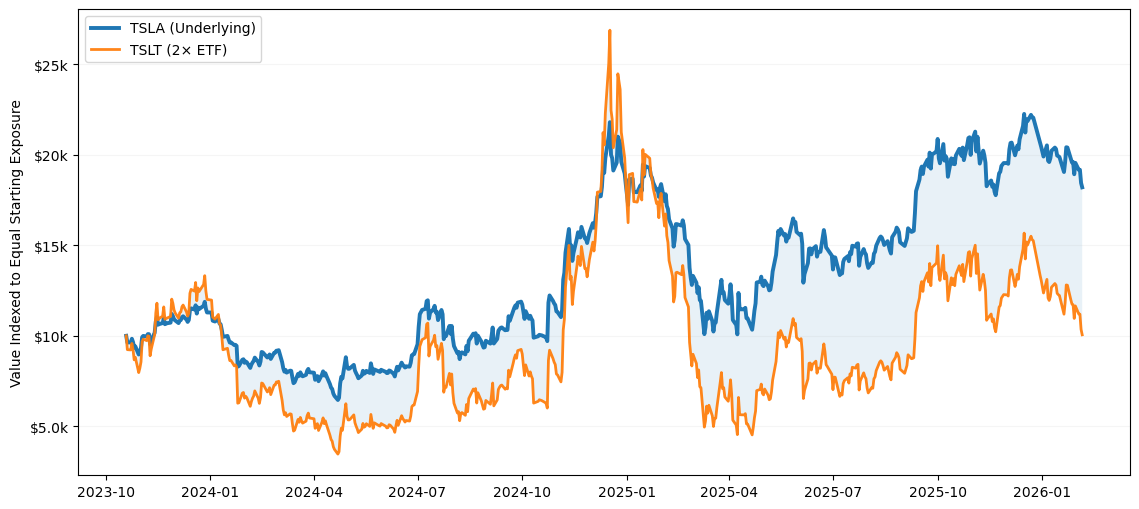

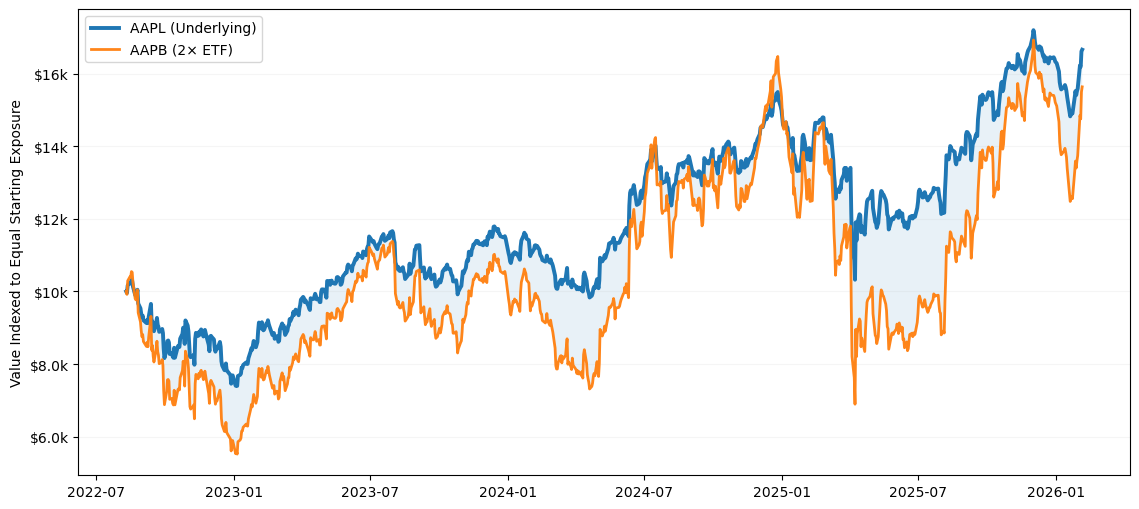

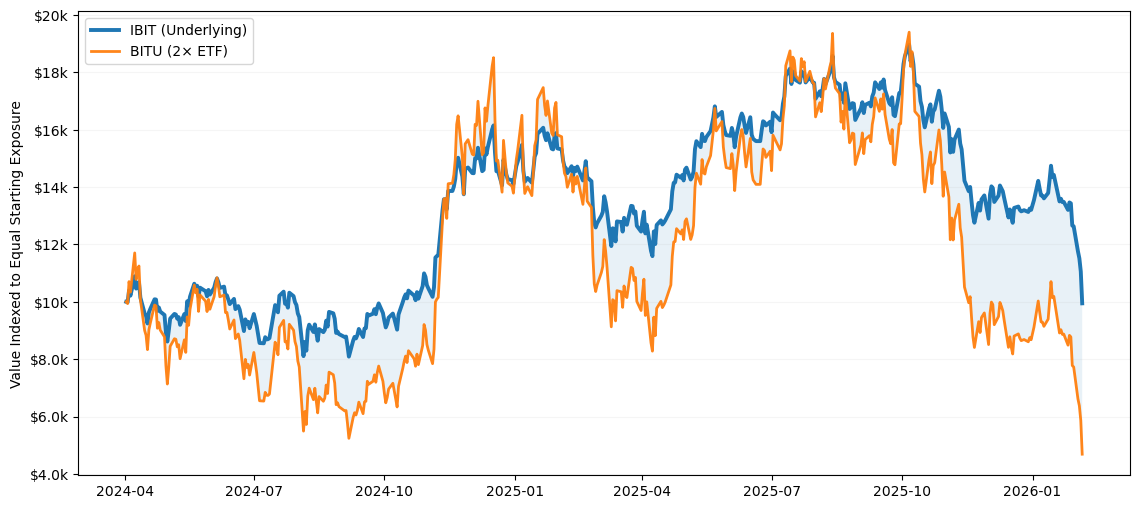

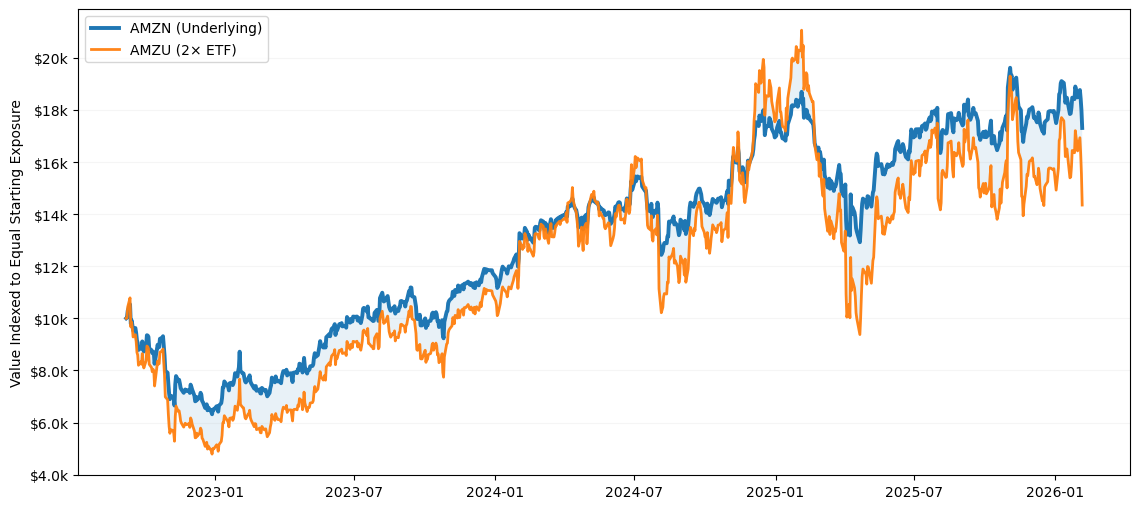

        pair      start        end  end_under_$10k  end_lev_$10k  end_diff_$  max_diff_$   min_diff_$
TSLA vs TSLT 2023-10-19 2026-02-05    18201.916946  10055.729529 8146.187418 8146.187418 -5081.173030
AAPL vs AAPB 2022-08-10 2026-02-05    16656.490695  15633.391607 1023.099088 3427.256270  -978.453455
IBIT vs BITU 2024-04-02 2026-02-05     9946.809320   4686.414604 5260.394717 5260.394717 -2362.690465
AMZN vs AMZU 2022-09-07 2026-02-05    17307.693350  14349.224183 2958.469167 3544.731257 -2364.852560


In [93]:
# LP-READY CHART (SINGLE AXIS): Growth of $10,000 with shaded divergence
# - One axis only (no dollar gap axis)
# - Underlying emphasized, ETF de-emphasized
# - Shaded area between lines shows divergence intuitively
# - Minimal grid, simple legend, no title/footnote by default

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def fetch_adj_close(tickers, start="2020-01-01", end=None) -> pd.DataFrame:
    px = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        auto_adjust=False,
        progress=False,
        threads=True,
        group_by="ticker",
    )

    if isinstance(tickers, str) or len(tickers) == 1:
        t = tickers if isinstance(tickers, str) else tickers[0]
        if "Adj Close" not in px.columns:
            raise ValueError(f"No 'Adj Close' for {t}.")
        return px[["Adj Close"]].rename(columns={"Adj Close": t})

    if "Adj Close" in px.columns.get_level_values(0):
        out = px["Adj Close"].copy()
    elif "Adj Close" in px.columns.get_level_values(-1):
        out = px.xs("Adj Close", axis=1, level=-1)
    else:
        raise ValueError("Could not find 'Adj Close' in downloaded data.")
    return out


def _dollar_formatter(x, pos):
    # compact dollar formatter (k for thousands)
    sign = "-" if x < 0 else ""
    x = abs(x)
    if x >= 1_000_000:
        return f"{sign}${x/1_000_000:.1f}m"
    if x >= 1000:
        return f"{sign}${x/1000:.0f}k" if x >= 10000 else f"{sign}${x/1000:.1f}k"
    return f"{sign}${x:.0f}"


def plot_lp_ready_single_axis(
    under: str,
    lev: str,
    start="2020-01-01",
    end=None,
    initial_investment=10_000,
    under_label=None,
    lev_label=None,
    shade_alpha=0.10,
    show_title=False,
):
    under_label = under_label or f"{under} (Underlying)"
    lev_label   = lev_label   or f"{lev} (2× ETF)"

    adj = fetch_adj_close([under, lev], start=start, end=end)[[under, lev]].dropna()
    if len(adj) < 30:
        print(f"[WARN] Not enough overlap data for {under} vs {lev}.")
        return None

    under_val = initial_investment * (adj[under] / adj[under].iloc[0])
    lev_val   = initial_investment * (adj[lev]   / adj[lev].iloc[0])

    fig, ax = plt.subplots(figsize=(11.5, 5.2))

    # Minimal grid (y-only)
    ax.grid(axis="y", alpha=0.12)
    ax.grid(axis="x", alpha=0.0)

    # Lines: underlying dominant, ETF slightly lighter
    ax.plot(under_val.index, under_val.values, linewidth=2.8, label=under_label)
    ax.plot(lev_val.index,   lev_val.values,   linewidth=2.0, alpha=0.95, label=lev_label)

    # Shaded divergence area
    ax.fill_between(
        under_val.index,
        under_val.values,
        lev_val.values,
        alpha=shade_alpha,
        linewidth=0
    )

    ax.set_ylabel("Value Indexed to Equal Starting Exposure")
    ax.yaxis.set_major_formatter(FuncFormatter(_dollar_formatter))

    # Clean legend
    ax.legend(loc="upper left", frameon=True)

    if show_title:
        ax.set_title(f"{under} vs {lev}")

    plt.tight_layout()
    plt.show()

    return {
        "pair": f"{under} vs {lev}",
        "start": str(adj.index[0].date()),
        "end": str(adj.index[-1].date()),
        "end_under_$10k": float(under_val.iloc[-1]),
        "end_lev_$10k": float(lev_val.iloc[-1]),
        "end_diff_$": float((under_val - lev_val).iloc[-1]),
        "max_diff_$": float((under_val - lev_val).max()),
        "min_diff_$": float((under_val - lev_val).min()),
    }


# --- Run set ---
pairs = [
    ("TSLA", "TSLT"),
    ("AAPL", "AAPB"),
    ("IBIT", "BITU"),
    ("AMZN", "AMZU"),
]

summaries = []
for u, l in pairs:
    s = plot_lp_ready_single_axis(u, l, start="2020-01-01", initial_investment=10_000)
    if s:
        summaries.append(s)

if summaries:
    print(pd.DataFrame(summaries).to_string(index=False))


In [ ]:
import re
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

NASDAQ_LISTED_URL = "https://www.nasdaqtrader.com/dynamic/symdir/nasdaqlisted.txt"
OTHER_LISTED_URL  = "https://www.nasdaqtrader.com/dynamic/symdir/otherlisted.txt"

def _read_nasdaq_pipe_file(url: str) -> pd.DataFrame:
    df = pd.read_csv(url, sep="|", dtype=str)
    # last row is a file timestamp; drop it
    df = df[~df.iloc[:, 0].astype(str).str.contains("File Creation Time", na=False)].copy()
    return df

def load_all_us_symbols() -> pd.DataFrame:
    n = _read_nasdaq_pipe_file(NASDAQ_LISTED_URL)
    o = _read_nasdaq_pipe_file(OTHER_LISTED_URL)

    # Normalize columns
    n = n.rename(columns={"Symbol": "ticker", "Security Name": "name", "ETF": "is_etf"})
    o = o.rename(columns={"ACT Symbol": "ticker", "Security Name": "name", "ETF": "is_etf"})

    keep_cols = ["ticker", "name", "is_etf"]
    df = pd.concat([n[keep_cols], o[keep_cols]], ignore_index=True)
    df["ticker"] = df["ticker"].str.strip()
    df["name"]   = df["name"].str.strip()
    df["is_etf"] = df["is_etf"].str.strip()
    df = df.dropna(subset=["ticker", "name", "is_etf"]).drop_duplicates(subset=["ticker"])
    return df

# Conservative name-based filter: you can tighten/loosen this
LEV_PATTERNS = [
    r"\b2x\b", r"\b3x\b", r"\b-2x\b", r"\b-3x\b",
    r"\bull\b", r"\bbear\b",
    r"\bultra\b", r"\bultrapro\b",
    r"\binverse\b", r"\bleveraged\b",
    r"\bdaily\b",
    r"\bshort\b",  # catches "short" ETFs (be careful: can include non-levered)
]

# Exclusions to reduce false positives (optional)
EXCLUDE_PATTERNS = [
    r"\bultra short\b",   # can be duration, not leverage
    r"\bultrashort\b",
    r"\bshort[- ]term\b", # duration
]

def is_leveraged_name(name: str) -> bool:
    s = name.lower()
    if any(re.search(p, s) for p in EXCLUDE_PATTERNS):
        return False
    return any(re.search(p, s) for p in LEV_PATTERNS)

def infer_first_trade_date(ticker: str) -> pd.Timestamp | None:
    try:
        h = yf.download(ticker, period="max", auto_adjust=False, progress=False)
        if h is None or h.empty:
            return None
        return pd.to_datetime(h.index[0]).tz_localize(None)
    except Exception:
        return None

def build_leveraged_universe(max_tickers: int | None = None) -> pd.DataFrame:
    df = load_all_us_symbols()

    # ETFs only
    df = df[df["is_etf"].eq("Y")].copy()

    # Leveraged/inverse by name
    df["is_leveraged_guess"] = df["name"].apply(is_leveraged_name)
    df = df[df["is_leveraged_guess"]].copy()

    # Optional: cap for quick testing
    if max_tickers is not None:
        df = df.head(max_tickers).copy()

    # First-trade date proxy via yfinance
    first_dates = []
    for t in df["ticker"]:
        first_dates.append(infer_first_trade_date(t))

    df["first_price_date"] = first_dates
    df = df.dropna(subset=["first_price_date"]).copy()
    df["first_price_date"] = pd.to_datetime(df["first_price_date"])
    return df

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

def plot_leveraged_count_over_time(df: pd.DataFrame, freq: str = "M"):
    # freq: "M" monthly, "Q" quarterly

    launched = (
        df.assign(period=df["first_price_date"].dt.to_period(freq).dt.to_timestamp())
          .groupby("period")["ticker"].nunique()
          .sort_index()
    )

    outstanding = launched.cumsum()

    fig, ax = plt.subplots(figsize=(11, 4.6))

    # Main line
    ax.plot(
        outstanding.index,
        outstanding.values,
        linewidth=2.8
    )

    # --- Axes labels (clean, PPT-friendly) ---
    ax.set_ylabel("Number of Leveraged & Inverse ETFs", fontsize=11)
    ax.set_xlabel("")

    # --- X-axis formatting (sparse, readable) ---
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis="x", labelsize=10)
    ax.tick_params(axis="y", labelsize=10)

    # --- Y-axis formatting (integers only) ---
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

    # --- Grid (LP style) ---
    ax.grid(axis="y", alpha=0.18, linewidth=1.0)
    ax.grid(axis="x", alpha=0.0)

    # --- Clean spines ---
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # --- Margins for right-edge breathing room ---
    ax.margins(x=0.03)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame({
        "launched": launched,
        "outstanding": outstanding
    })

# ---- RUN ----
lev = build_leveraged_universe()  # optionally: build_leveraged_universe(max_tickers=300)


: 

: 

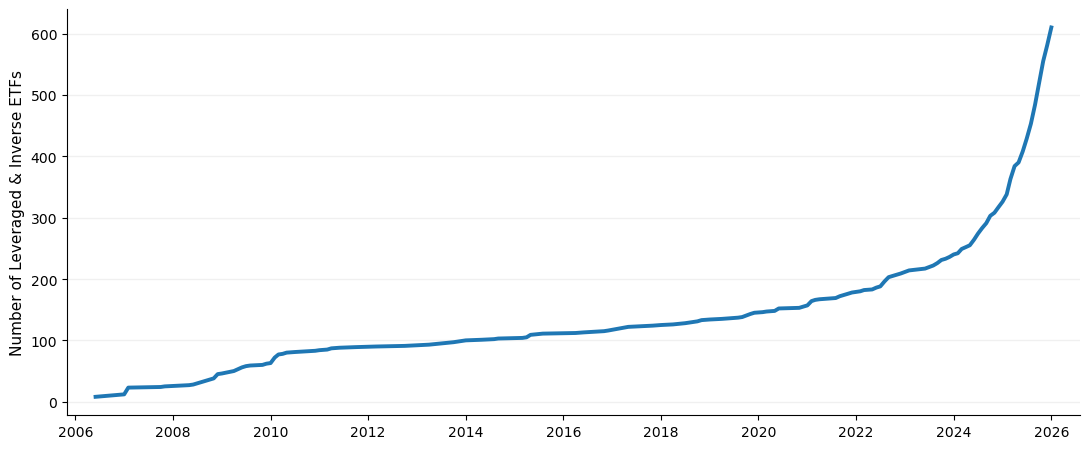

,launched,outstanding
period,,
2006-06-01,8,8
2007-01-01,4,12
2007-02-01,11,23
2007-10-01,1,24
2007-11-01,1,25
...,...,...
2025-09-01,31,484
2025-10-01,35,519
2025-11-01,36,555


: 

: 

In [ ]:
plot_leveraged_count_over_time(lev)

In [ ]:
import re
import time
import random
import pandas as pd
import requests
from bs4 import BeautifulSoup

ETF_CAGR_PATH = "../config/etf_cagr.csv"
OUT_EXPENSE_CSV = "etf_expense_ratios_2x.csv"
OUT_SUMMARY_CSV = "expense_ratio_summary_2x.csv"

HEADERS = {
    "User-Agent": "Mozilla/5.0 (compatible; ExpenseRatioBot/1.0; +https://example.com)"
}

def parse_percent_to_float(s: str):
    """
    Convert strings like '0.95%' -> 0.0095
    Return None if cannot parse.
    """
    if not isinstance(s, str):
        return None
    m = re.search(r"([-+]?\d+(\.\d+)?)\s*%", s)
    if not m:
        return None
    return float(m.group(1)) / 100.0

def fetch_etfdb_expense_ratio(ticker: str):
    """
    Scrape expense ratio from ETFdb ETF page:
      https://etfdb.com/etf/{TICKER}/
    Returns (expense_ratio_float, raw_text, url) or (None, None, url) on failure.
    """
    url = f"https://etfdb.com/etf/{ticker}/"
    try:
        r = requests.get(url, headers=HEADERS, timeout=20)
        if r.status_code != 200:
            return None, None, url

        soup = BeautifulSoup(r.text, "html.parser")

        # ETFdb typically shows "Expense Ratio" in the "Vitals" / "Basics" section.
        # We'll find the label text and grab the adjacent value.
        label = soup.find(string=re.compile(r"\bExpense Ratio\b", re.I))
        if not label:
            return None, None, url

        # Walk up to a container row and find the value.
        # This is intentionally a bit flexible to survive minor HTML changes.
        container = label.find_parent()
        # Search nearby for a percent
        text_window = container.get_text(" ", strip=True)
        # Sometimes label container doesn't include value; expand to parent
        if "%" not in text_window:
            parent = container.find_parent()
            if parent:
                text_window = parent.get_text(" ", strip=True)

        # Find first percent in that window
        m = re.search(r"([-+]?\d+(\.\d+)?)\s*%", text_window)
        if not m:
            return None, None, url

        raw = m.group(0)
        val = parse_percent_to_float(raw)
        return val, raw, url

    except Exception:
        return None, None, url

def main():
    etf_cagr = pd.read_csv(ETF_CAGR_PATH)

    # You said: "only read ETFs and corresponding underlyings classified as 2x"
    df_2x = etf_cagr[etf_cagr["LevType"].astype(str).str.lower().eq("2x")].copy()
    tickers = sorted(df_2x["ETF"].astype(str).str.upper().unique())

    rows = []
    for i, tkr in enumerate(tickers, 1):
        val, raw, url = fetch_etfdb_expense_ratio(tkr)

        rows.append({
            "ticker": tkr,
            "expense_ratio": val,          # decimal (e.g. 0.0095)
            "expense_ratio_raw": raw,      # string (e.g. '0.95%')
            "source_url": url,
            "ok": val is not None
        })

        # polite throttle to avoid getting blocked
        time.sleep(0.6 + random.random() * 0.7)

        if i % 25 == 0:
            print(f"Scraped {i}/{len(tickers)}...")

    out = pd.DataFrame(rows)
    out.to_csv(OUT_EXPENSE_CSV, index=False)

    # ----- compute the averages you want -----
    # Long side: corresponding underlyings (stocks) => 0 expense ratio by definition
    # Short side: the 2x ETFs => average of scraped expense ratios
    short_avg = out.loc[out["ok"], "expense_ratio"].mean()

    summary = pd.DataFrame([{
        "n_2x_etfs_total": len(out),
        "n_2x_etfs_with_expense_ratio": int(out["ok"].sum()),
        "avg_expense_ratio_short_2x_etfs": short_avg,
        "avg_expense_ratio_long_underlyings": 0.0,
        "fee_differential_short_minus_long": (short_avg - 0.0) if short_avg is not None else None
    }])
    summary.to_csv(OUT_SUMMARY_CSV, index=False)

    print("\nSaved:")
    print(f" - {OUT_EXPENSE_CSV}")
    print(f" - {OUT_SUMMARY_CSV}")
    print("\nSummary:")
    print(summary.to_string(index=False))

if __name__ == "__main__":
    main()


Scraped 25/236...
Scraped 50/236...
Scraped 75/236...
Scraped 100/236...
Scraped 125/236...
Scraped 150/236...
Scraped 175/236...
Scraped 200/236...
Scraped 225/236...

Saved:
 - etf_expense_ratios_2x.csv
 - expense_ratio_summary_2x.csv

Summary:
 n_2x_etfs_total  n_2x_etfs_with_expense_ratio  avg_expense_ratio_short_2x_etfs  avg_expense_ratio_long_underlyings  fee_differential_short_minus_long
             236                           228                         0.011108                                 0.0                           0.011108


: 

: 

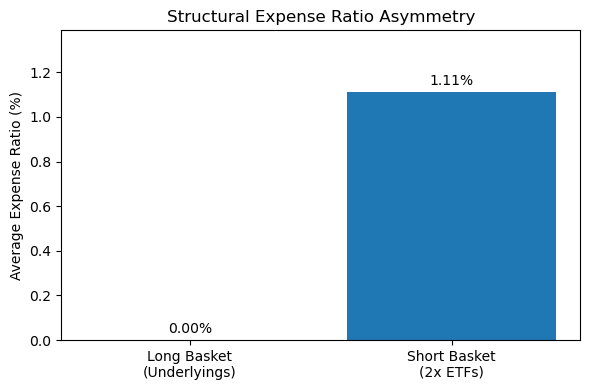

: 

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# Load expense ratio data (2x ETFs)
# -------------------------------------------------
df = pd.read_csv("etf_expense_ratios_2x.csv")

# Keep only successfully scraped rows
df = df[df["ok"] == True].copy()

# -------------------------------------------------
# Compute averages
# -------------------------------------------------
short_avg = df["expense_ratio"].mean()      # decimal (e.g. 0.0111)
long_avg = 0.0                              # underlyings assumed 0%

# Convert to percentages for display
values = [long_avg * 100, short_avg * 100]
labels = [
    "Long Basket\n(Underlyings)",
    "Short Basket\n(2x ETFs)"
]

# -------------------------------------------------
# Plot
# -------------------------------------------------
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values)

plt.ylabel("Average Expense Ratio (%)")
plt.title("Structural Expense Ratio Asymmetry")

# Annotate values above bars
for bar, val in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{val:.2f}%",
        ha="center",
        va="bottom"
    )

# Clean, LP-friendly formatting
plt.ylim(0, max(values) * 1.25)
plt.tight_layout()

plt.show()


: 

: 